# Final Project Submission

Please fill out:
* Student name: Darius Fuller
* Student pace: Part-time
* Scheduled project review date/time: 12/9/2019 
* Instructor name: James Irving
* Blog post URL:https://medium.com/@d_full22/my-first-data-science-project-3e9f93e3ceb8
* Video of 5-min Non-Technical Presentation: https://youtu.be/JBZgxmkv5Cg


# TABLE OF CONTENTS 

*Click to jump to matching Markdown Header.*<br><br>

<font size=4rem>
    
- [Introduction](#INTRODUCTION)<br>
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- [Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>
</font>
___


# INTRODUCTION

My goal with this project is to determine what are the top three factors that have the most influence on the price of a given home in King County, 
Washington. 

I will be taking the position of a real estate professional looking to create a model that can help me gain a reference point for understanding 
how much to reasonably sell or buy a home.

Negotiations can be tough and prices are not always based within reason, so having a tool to help determine a realistic price point for the home will provide me with a discrete price region to target during the negotiation process.
    
> I will try to find (if any):
   * Top three positive/negative predictors for price
   * Whether or not the waterfront carries any weight on price
   * Differences between multi and single story homes

# OBTAIN

> #### Importing necessary packages

In [1]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore")

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import math
from scipy import stats
!pip install -U fsds_100719
from fsds_100719.imports import *

fsds_1007219  v0.4.45 loaded.  Read the docs: https://fsds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds_100719,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


> #### Grabbing the dataset

In [3]:
pd.set_option('display.max_columns',0)
csv="https://raw.githubusercontent.com/learn-co-students/dsc-v2-mod1-final-project-online-ds-pt-100719/master/kc_house_data.csv"
kc_house_df = pd.read_csv(csv)

> #### Functions used throughout

In [4]:
def minmaxscaler(dataseries):
    """Takes in a pandas.series and returns a min-max
        scaled verison of the series. Can also take in iterable
        objects like lists.
    
    Args:
        dataseries (obj.): contains the values to be 
            scaled.
            
    Return:
        dataseries: min-max scaled copy of dataseries arg
    """
    return (dataseries - min(dataseries)) / (max(dataseries) - min(dataseries))

In [5]:
def nrmlizer(dataseries):
    """Takes in a pandas.series and returns a mean normalized
        verison of the series. Can also take in iterable
        objects like lists.
    
    Args:
        dataseries (obj.): contains the values to be 
            scaled.
            
    Return:
        dataseries: mean normalized copy of dataseries arg
    """
    return (dataseries - np.mean(dataseries)) / (max(dataseries) - min(dataseries))

In [6]:
def dot_product(x, y):
    """Takes in two interable objects and returns a single
        int or float dot product of them. 
    
    Args:
        x (obj.): contains the values to be multiplied.
        y (obj.): contains the values to be multiplied.
            
    Return:
        total: dot product of x and y 
            ** = (x[0]*y[0]) + (x[1]*y[1])...(x[n]*y[n])
    """
    Xdummy = list(x)
    Ydummy = list(y)
    total = 0
    for idx in list(range(0, len(x))):
        total += (Xdummy[idx]*Ydummy[idx]) 
    return total

In [7]:
def correlation(var1, var2):
    """Takes in two interable objects and returns a single
        value representing the Pearson correlation bewtween them.
        If the objects are unequal in length, the function stops.
    
    Args:
        var1 (obj.): contains the values to be correlated.
        var2 (obj.): contains the values to be correlated.
            
    Return:
        Pearson correlation value of var1/var2  
    """    
    if len(var1) != len(var2):
        return 'The lengths of both the lists should be equal.' 
    
    else: 
        mean_norm_var1 = nrmlizer(var1)
        mean_norm_var2 = nrmlizer(var2)
        
        var1_dot_var2 = dot_product(mean_norm_var1, mean_norm_var2)
        
        var1_squared = [i * i for i in mean_norm_var1]
        var2_squared = [i * i for i in mean_norm_var2]
        
        return round(var1_dot_var2 / math.sqrt(sum(var1_squared) * sum(var2_squared)), 2)

In [8]:
def check_column(df, col_name, target):
    """Displays info on null values, datatype, correlation,
        value counts and displays .describe()
    
    Args:
        df (df): contains the columns
        col_name (str): name of the df column to show
        n_unique (int): Number of unique values top show.
        target (str): name of the df column to be y for df.plot
    
    Return:
        fig, ax (Matplotlib Figure and Axes)
        
        ax[0]: KDE plot of col_name
        ax[1]: scatterplot of col_name and target
    """
    print('DataType:')
    print('\t',df[col_name].dtypes)
    
    num_nulls = df[col_name].isna().sum()
    print(f'Null Values Present = {num_nulls}')
    
    display(df[col_name].describe().round(decimals=3))
    
    print('\nValue Counts:')
    display(df[col_name].value_counts().head())
    
    print('\nCorrelation:')
    display(correlation(df[col_name], df[target]))
    
    fig, ax = plt.subplots(ncols=2, figsize=(18,10));
    
    df[col_name].plot.hist(density=True, label=col_name + 'Histogram', ax=ax[0]);
    df.plot(kind='scatter', x=col_name, y=target, label=col_name, ax=ax[1]);
    
    return fig,ax;

In [9]:
def grab_outliers(series):
    """Takes in an interable obj of z-score values 
        (designed for pandas.series) and outputs a list
        of boolean values using abs(value) < 3 as a threshold.
    
    Args:
        series (obj.): iterable object of z-score values
    
    Return:
        outlie (list): list of boolean values corresponding
            to 'series' input.
            * True = outlier
    """
    outlie = []
    for idx in list(range(0, len(series))):
        if abs(series[idx]) > 3:
            outlie.append(True)
        else:
            outlie.append(False)
    return outlie

In [10]:
def outlie_drop_bycol(df, col_name):
    """Takes in a pd.DataFrame and one of its columns.
        Function will go to column and each row, dropping the
        row from the DataFrame inplace with outliers in that
        column with respect to z-scores within -3 and 3.
    
    Args:
        df (pd.DataFrame): DataFrame
        col_name (str): 'name' of targeted column 
    
    Return:
        .describe() of new column without outliers
    """
    #'column' of z-scores
    z_col = pd.Series(stats.zscore(df[col_name]))
    
    #'column' of T/F for [abs(z-score) > 3] 
    z_col_outlie = pd.Series(grab_outliers(z_col))
    
    #dropping rows with True values from df 'inplace'
    for idx, item in zip(list(range(0, len(z_col_outlie))), z_col_outlie):
        if z_col_outlie[idx] == True:
            df.drop(idx, axis=0, inplace=True)
        else:
            pass
        
    #check results
    return df[col_name].describe()

In [11]:
def kde_hist_plot(data):
    """Takes in a pd.DataFrame. Function will go to each
        column, producing a subplot with a hist/kde overlay.
        
    Args:
        data (pd.DataFrame): DataFrame
            
    Return:
        plt.plot() figure for each column with histogram/kde combo 
    """
    for col in data:
        data[col].plot.hist(density=True, label=col + ' Historgram')
        #data[col].plot.kde(label=col + ' KDE')
        plt.legend()
        plt.show()

# SCRUB

## Varibable Definitions

>* **id** - unique identified for a house
>* **date** - house was sold
>* **price** -  is prediction target
>* **bedrooms** -  of Bedrooms/House
>* **bathrooms** -  of bathrooms/bedrooms
>* **sqft_living** -  footage of the home
>* **sqft_lot** -  footage of the lot
>* **floors** -  floors (levels) in house
>* **waterfront** - House which has a view to a waterfront
>* **view** - Has been viewed
>* **condition** - How good the condition is ( Overall )
>* **grade** - overall grade given to the housing unit, based on King County grading system
>* **sqft_above** - square footage of house apart from basement
>* **sqft_basement** - square footage of the basement
>* **yr_built** - Built Year
>* **yr_renovated** - Year when house was renovated
>* **zipcode** - zip
>* **lat** - Latitude coordinate
>* **long** - Longitude coordinate
>* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
>* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

## Scatter matrix to check briefly

* When I first tried to run, it took a while, so I decided to split into smaller dataframes, making sure to include price in both

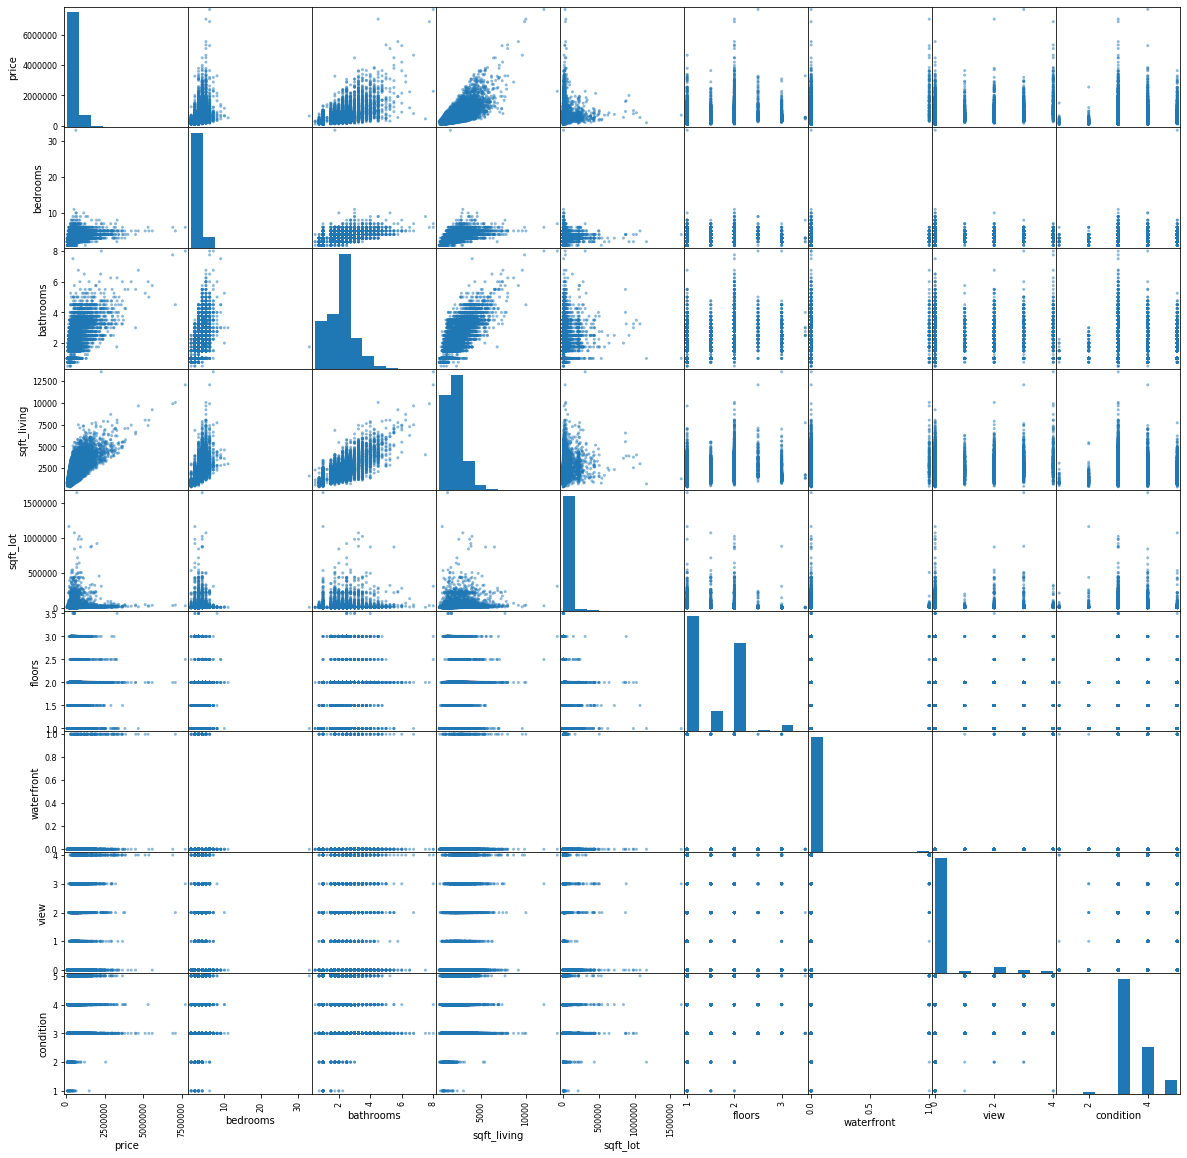

In [12]:
pd.plotting.scatter_matrix(kc_house_df[['price', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition']], figsize=((20,20)));

* For the above scatter matrix, it is clear that a couple of the variables have positive correlations with each other, like the square footage and room counts. Otherwise, I have a lot of categorical variables. 
* View for example does not visually appear to have any effect on anything, and with there being a high skew, this may be dropped.
* Of the continuous variables, they seem to have a slight skew and will need to be transformed. The categorical variables are highly skewed

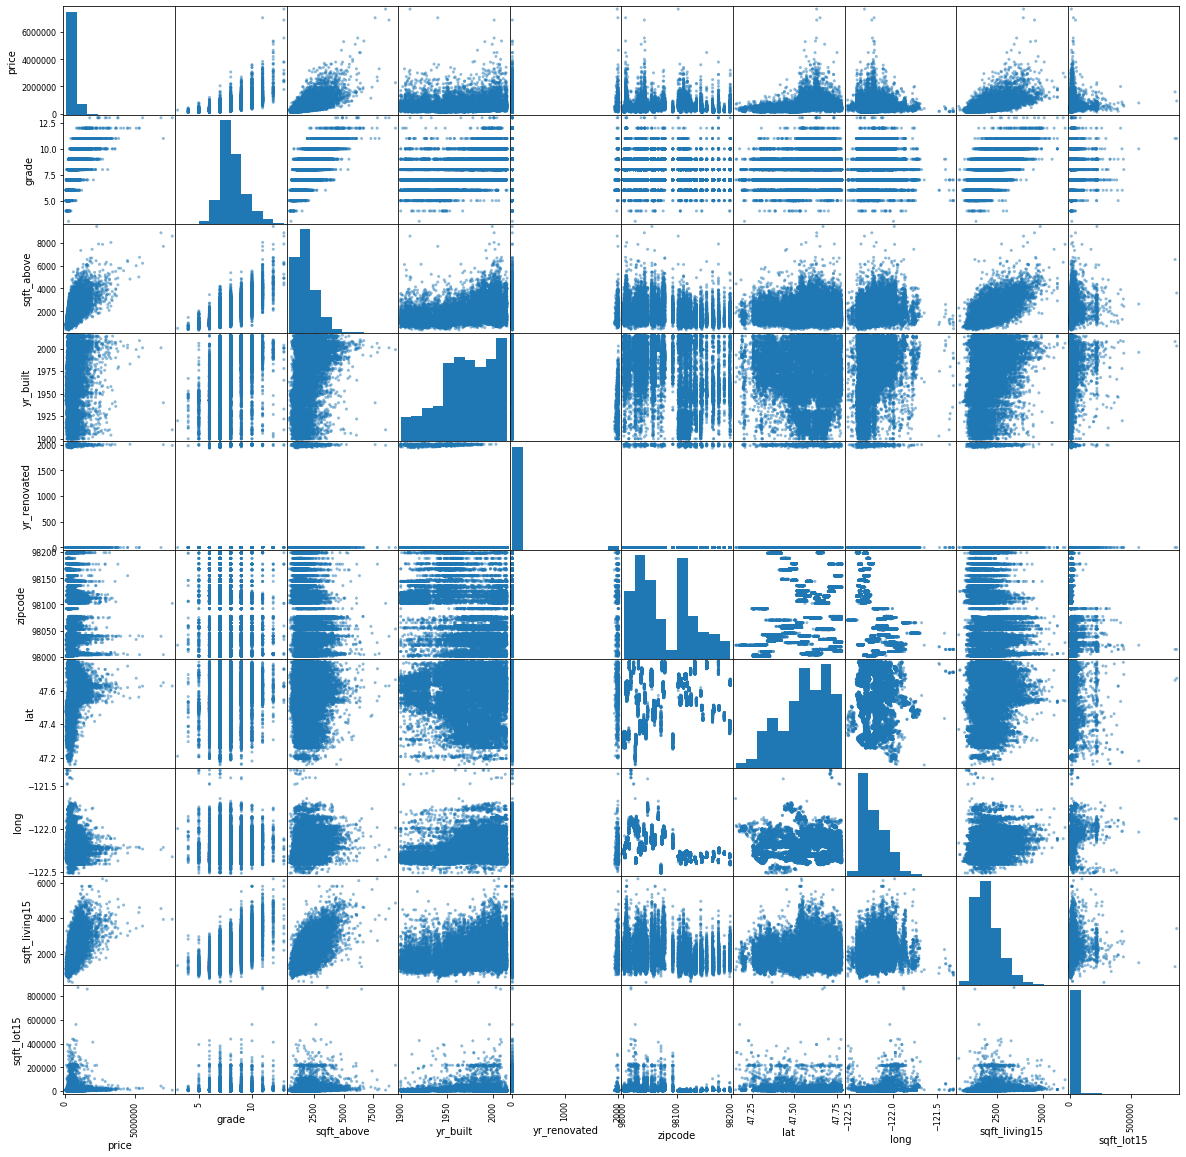

In [13]:
pd.plotting.scatter_matrix(kc_house_df[['price', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']], figsize=((20,20)));

* Similar to the first matrix, the only variables to carry a visually identifiable correlation with price are square footage variables (excluding sqft_lot15). Grade is a categorical variable that for sure has a correlation. As for the locational data (lat, long, and zipcode) there appears to be some correlation, but its hard to tell whether or not the connection is strong enough to be significant.
* It is obvious that yr_renovated does not have much impact on price visually, nor any other variable, and since the bulk of data have a 0 for this category, it will be a strong candidate to drop. 

> After looking at both matrices, there are a couple features I already have in mind to drop. A few potential drops that I will need to look further at, but I will make sure to cut out some of the square footage variables, as they will guaranteed carry correlation and interfere with eachother since the individual home's square footage could be calculated within the 15 nearest neighbors. Additionally, things such as condition and grade describe the same thing about a house. I will need to determine how to deal with the zipcode/lat/long variables, as they will have captured, in essence, the same info about a home. 

## Working column by column

### 'Id'

DataType:
	 int64
Null Values Present = 0


count    2.159700e+04
mean     4.580474e+09
std      2.876736e+09
min      1.000102e+06
25%      2.123049e+09
50%      3.904930e+09
75%      7.308900e+09
max      9.900000e+09
Name: id, dtype: float64


Value Counts:


795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
Name: id, dtype: int64


Correlation:


-0.02

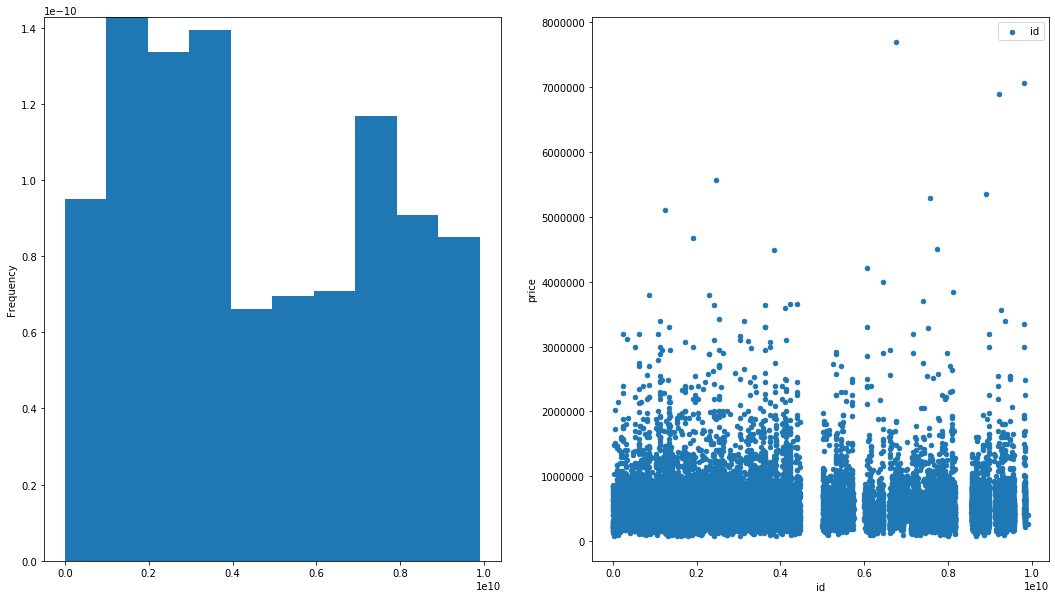

In [14]:
check_column(kc_house_df, 'id', 'price');

> Now that I've determined there are multiples for the same house, I will drop these because my goal is to find out what features lead to a price and having the _exact_ same home with different selling prices introduces time as a variable, which _is_ relevant in the real world, but is not controllable by any individual. One can influence how many bathrooms or square footage a home has however.

In [15]:
#creating a column of boolean values for duplicate IDs
dupe_idx = kc_house_df['id'].duplicated(keep='first')

#copying for safety
kc_house_nodupe = kc_house_df

#if corresponding index in kc_house_df matches True value, row is dropped
for idx in list(range(0, len(dupe_idx))):
   if dupe_idx[idx] == True:
      kc_house_nodupe.drop(idx, axis=0, inplace=True)
   else:
      pass

In [16]:
kc_house_nodupe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 21 columns):
id               21420 non-null int64
date             21420 non-null object
price            21420 non-null float64
bedrooms         21420 non-null int64
bathrooms        21420 non-null float64
sqft_living      21420 non-null int64
sqft_lot         21420 non-null int64
floors           21420 non-null float64
waterfront       19067 non-null float64
view             21357 non-null float64
condition        21420 non-null int64
grade            21420 non-null int64
sqft_above       21420 non-null int64
sqft_basement    21420 non-null object
yr_built         21420 non-null int64
yr_renovated     17616 non-null float64
zipcode          21420 non-null int64
lat              21420 non-null float64
long             21420 non-null float64
sqft_living15    21420 non-null int64
sqft_lot15       21420 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.6+ MB


> As seen above, there is a descrepancy between my indices (0-21596) and datapoints (21420). I will reset the index and drop the duplicate column

In [17]:
#reset index into new df for safety
kc_house_newidx = kc_house_nodupe.reset_index()

#drop 'index' column generated by .reset_index()
kc_house_newidx.drop('index', axis=1, inplace=True)

In [18]:
kc_house_newidx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21420 entries, 0 to 21419
Data columns (total 21 columns):
id               21420 non-null int64
date             21420 non-null object
price            21420 non-null float64
bedrooms         21420 non-null int64
bathrooms        21420 non-null float64
sqft_living      21420 non-null int64
sqft_lot         21420 non-null int64
floors           21420 non-null float64
waterfront       19067 non-null float64
view             21357 non-null float64
condition        21420 non-null int64
grade            21420 non-null int64
sqft_above       21420 non-null int64
sqft_basement    21420 non-null object
yr_built         21420 non-null int64
yr_renovated     17616 non-null float64
zipcode          21420 non-null int64
lat              21420 non-null float64
long             21420 non-null float64
sqft_living15    21420 non-null int64
sqft_lot15       21420 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.4+ MB


> #### Better!

### 'Date'

In [19]:
kc_house_newidx.drop('date', axis=1, inplace=True)

> I have decided to drop the 'date' column because of similar reasons to removing the duplicate IDs. This type of information related to the timing of the home being sold is not what I am looking to predict around and speaks more to the economy the house is being sold in rather than the home itself

### 'Price'

DataType:
	 float64
Null Values Present = 0


count      21420.000
mean      540739.304
std       367931.110
min        78000.000
25%       322500.000
50%       450000.000
75%       645000.000
max      7700000.000
Name: price, dtype: float64


Value Counts:


350000.0    172
450000.0    171
550000.0    156
500000.0    151
425000.0    150
Name: price, dtype: int64


Correlation:


1.0

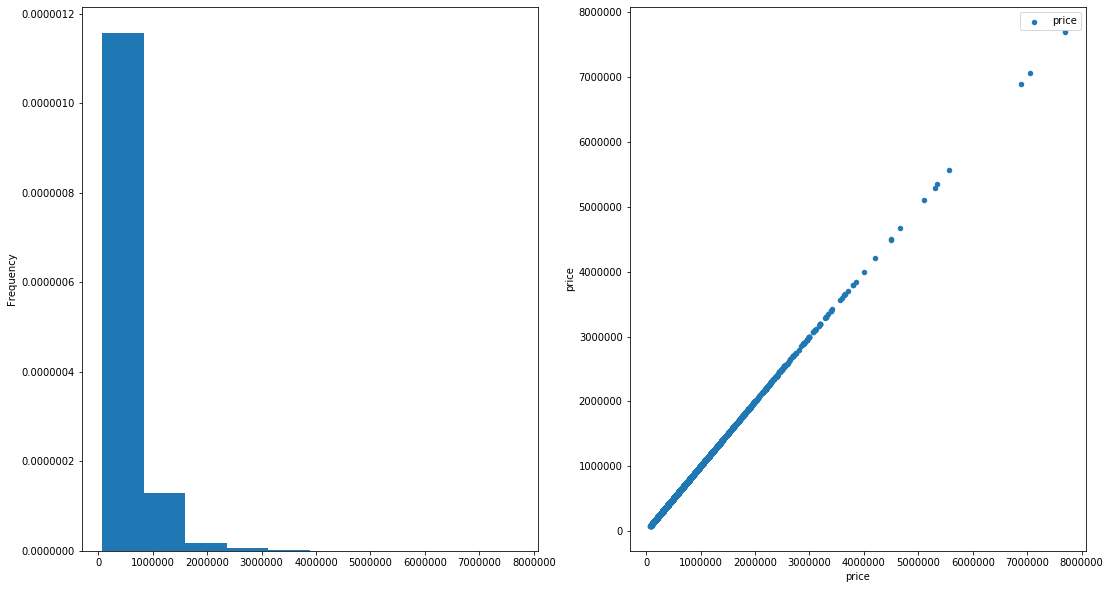

In [20]:
check_column(kc_house_newidx, 'price', 'price');

> Looking at this information, it is apparent there are some outliers that are skewing the data to the right. I will need to deal with these in order to ensure that my model has decent data to model off of. I will operate off of z-scores within -3 and 3.

In [21]:
#outlie_drop_bycol(kc_house_newidx, 'price')

In [22]:
#check_column(kc_house_newidx, 'price', 'price');

> Although not normal, this look a bit more managable to deal with.

In [23]:
kc_house_newidx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21420 entries, 0 to 21419
Data columns (total 20 columns):
id               21420 non-null int64
price            21420 non-null float64
bedrooms         21420 non-null int64
bathrooms        21420 non-null float64
sqft_living      21420 non-null int64
sqft_lot         21420 non-null int64
floors           21420 non-null float64
waterfront       19067 non-null float64
view             21357 non-null float64
condition        21420 non-null int64
grade            21420 non-null int64
sqft_above       21420 non-null int64
sqft_basement    21420 non-null object
yr_built         21420 non-null int64
yr_renovated     17616 non-null float64
zipcode          21420 non-null int64
lat              21420 non-null float64
long             21420 non-null float64
sqft_living15    21420 non-null int64
sqft_lot15       21420 non-null int64
dtypes: float64(8), int64(11), object(1)
memory usage: 3.3+ MB


* Need to .reset_index() again

In [24]:
#reset index into new df for safety
kc_house_newidx2 = kc_house_newidx.reset_index()

#drop 'index' column generated by .reset_index()
kc_house_newidx2.drop('index', axis=1, inplace=True)

### 'Bedrooms'

DataType:
	 int64
Null Values Present = 0


count    21420.000
mean         3.374
std          0.925
min          1.000
25%          3.000
50%          3.000
75%          4.000
max         33.000
Name: bedrooms, dtype: float64


Value Counts:


3    9731
4    6849
2    2736
5    1586
6     265
Name: bedrooms, dtype: int64


Correlation:


0.31

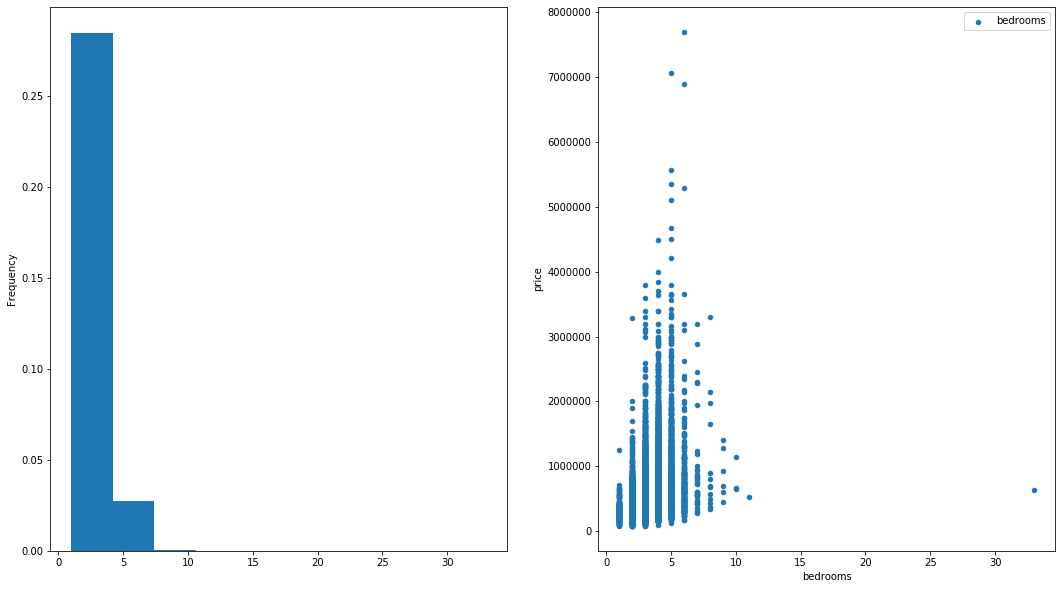

In [25]:
check_column(kc_house_newidx2, 'bedrooms', 'price');

> Need to drop the _ONE_ datapoint skewing this distribution so much. It looks to be the max value of 33. Otherwise the large majority of datapoints fall bewteen the IQR. 

In [26]:
#finding the index of the 33 room home
kc_house_newidx2[kc_house_newidx2['bedrooms'] == 33]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15710,2402100895,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,5,7,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700


In [27]:
#drop it!
kc_house_newidx2.drop(15710, axis=0, inplace=True)

DataType:
	 int64
Null Values Present = 0


count    21419.000
mean         3.373
std          0.903
min          1.000
25%          3.000
50%          3.000
75%          4.000
max         11.000
Name: bedrooms, dtype: float64


Value Counts:


3    9731
4    6849
2    2736
5    1586
6     265
Name: bedrooms, dtype: int64


Correlation:


0.32

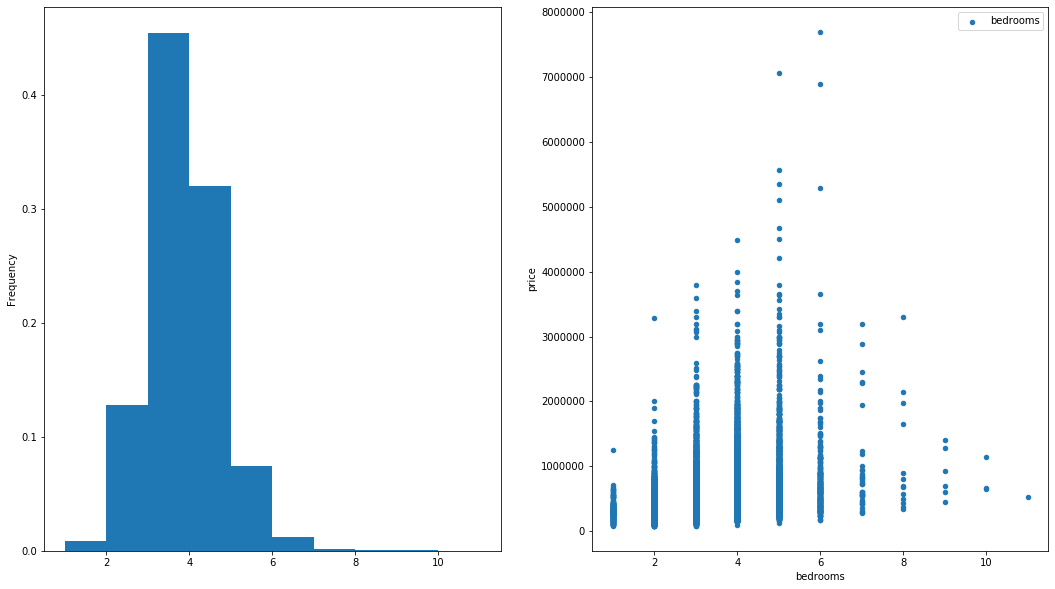

In [28]:
#recheck
check_column(kc_house_newidx2, 'bedrooms', 'price');

> #### Looks better!

### 'Bathrooms'

DataType:
	 float64
Null Values Present = 0


count    21419.000
mean         2.118
std          0.769
min          0.500
25%          1.750
50%          2.250
75%          2.500
max          8.000
Name: bathrooms, dtype: float64


Value Counts:


2.50    5352
1.00    3794
1.75    3019
2.25    2031
2.00    1913
Name: bathrooms, dtype: int64


Correlation:


0.53

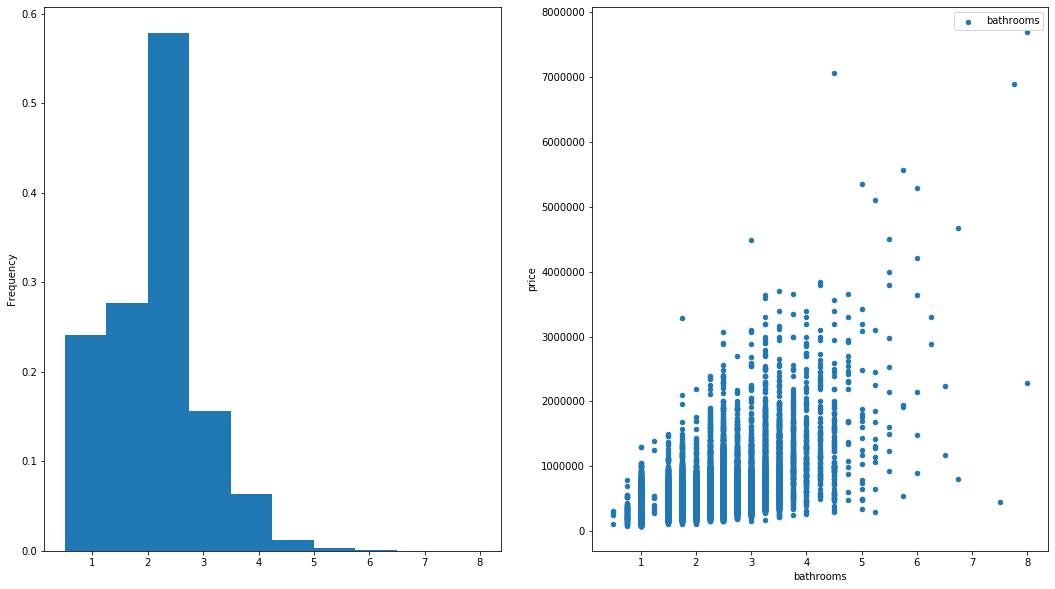

In [29]:
check_column(kc_house_newidx2, 'bathrooms', 'price');

> It appears to have a few outliers, I will check this with a boxplot, and then address them appropriately

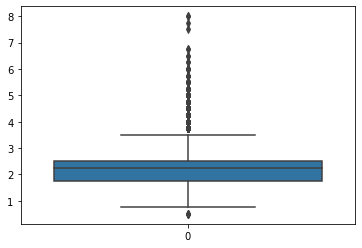

In [30]:
sns.boxplot(data=kc_house_newidx2['bathrooms']);

> According to this, I should be looking to drop any rows with more than 4 bathrooms. I will do so to see what I will get out of it.

DataType:
	 float64
Null Values Present = 0


count    21154.000
mean         2.086
std          0.713
min          0.500
25%          1.500
50%          2.250
75%          2.500
max          4.000
Name: bathrooms, dtype: float64


Value Counts:


2.50    5352
1.00    3794
1.75    3019
2.25    2031
2.00    1913
Name: bathrooms, dtype: int64


Correlation:


0.48

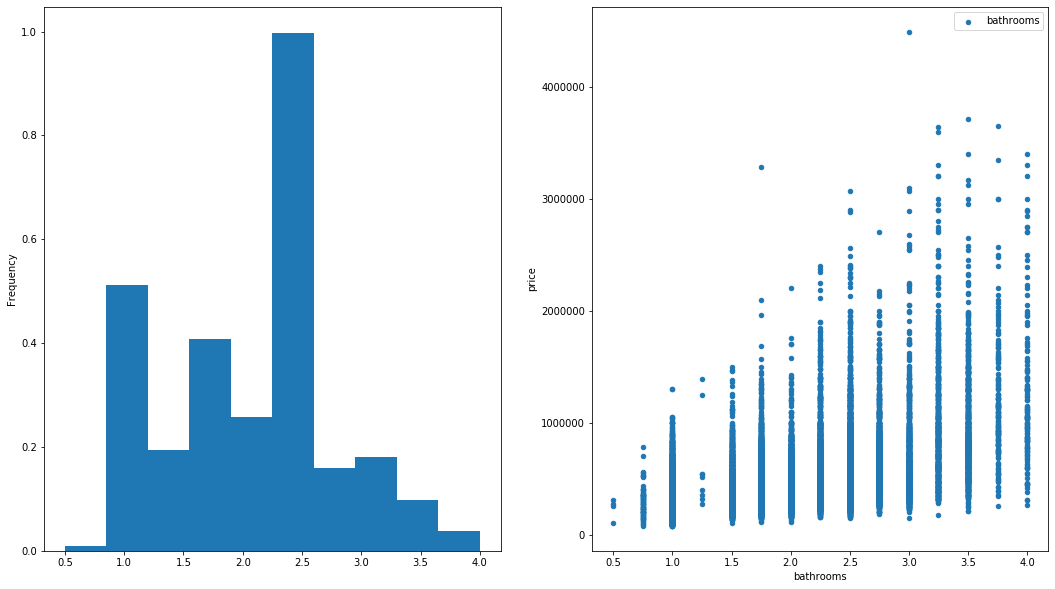

In [31]:
test_df = kc_house_newidx2[kc_house_newidx2['bathrooms'] <= 4]
check_column(test_df, 'bathrooms', 'price');

> Although this distribution looks better, I do want to investigate other columns further before dropping rows from the dataframe. I can always program something in to drop all outliers in one go.

### 'Sqft_living'

DataType:
	 int64
Null Values Present = 0


count    21419.000
mean      2083.154
std        918.824
min        370.000
25%       1430.000
50%       1920.000
75%       2550.000
max      13540.000
Name: sqft_living, dtype: float64


Value Counts:


1300    136
1440    133
1400    132
1660    128
1800    128
Name: sqft_living, dtype: int64


Correlation:


0.7

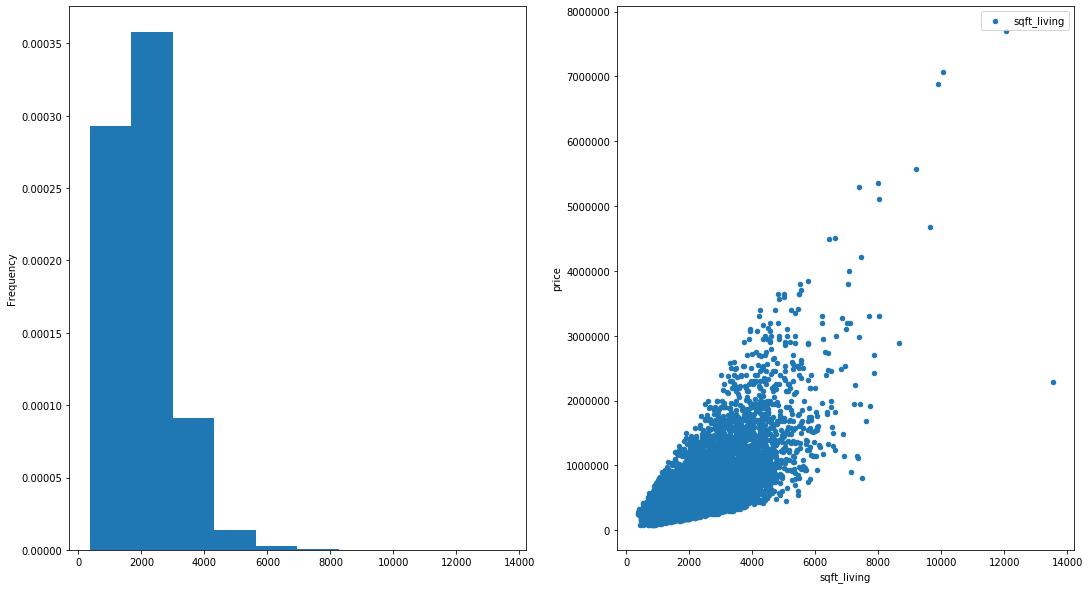

In [32]:
check_column(kc_house_newidx2, 'sqft_living', 'price');

> There is a strong correlation here as-is! I will definitely look to remove some outliers, since there appears to be a bit of a right-sided tail. I will need to pick one or two of these 'sqft' variables to keep, since I am assumming there will be collinearity between them.

### 'Sqft_lot'

DataType:
	 int64
Null Values Present = 0


count      21419.000
mean       15128.464
std        41531.720
min          520.000
25%         5040.000
50%         7614.000
75%        10692.000
max      1651359.000
Name: sqft_lot, dtype: float64


Value Counts:


5000    355
6000    285
4000    249
7200    218
7500    118
Name: sqft_lot, dtype: int64


Correlation:


0.09

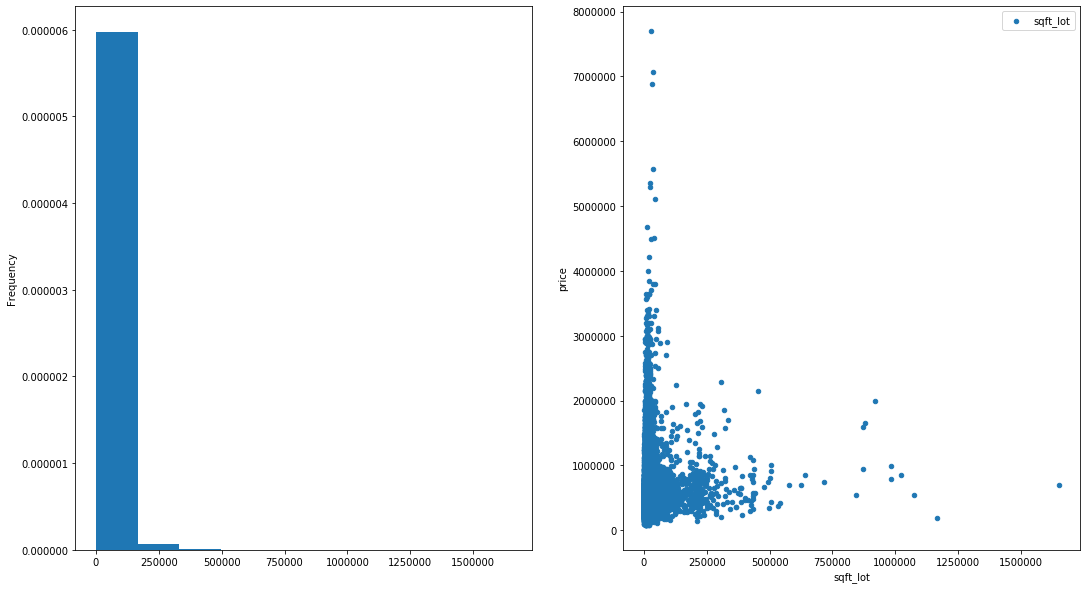

In [33]:
check_column(kc_house_newidx2, 'sqft_lot', 'price');

> Really low correlation and a large skew to the right. I will definitely need to remove outliers and/or normalize to 'unbunch' the data better. Will include this in the 'one shot' removal done later on.

> It also may not be very valuable as a predictor because near the zero mark on the scatter, the price variable goes to the top. It seems as the lot gets bigger, maybe indcating leaving city limits, the price isn't quite following this trend. 

### 'Floors'

DataType:
	 float64
Null Values Present = 0


count    21419.000
mean         1.496
std          0.540
min          1.000
25%          1.000
50%          1.500
75%          2.000
max          3.500
Name: floors, dtype: float64


Value Counts:


1.0    10551
2.0     8203
1.5     1888
3.0      609
2.5      161
Name: floors, dtype: int64


Correlation:


0.26

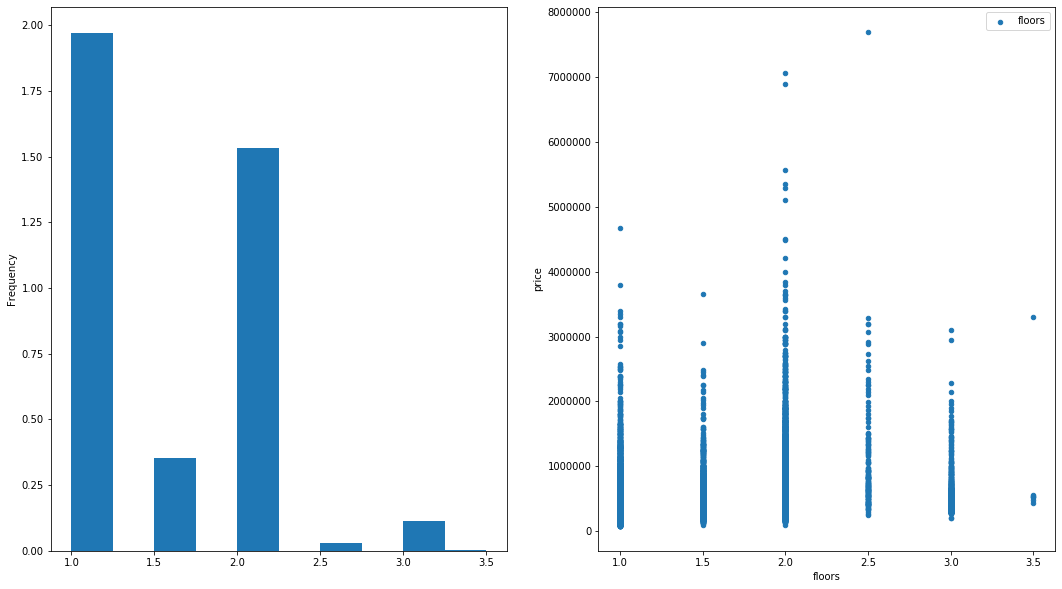

In [34]:
check_column(kc_house_newidx2, 'floors', 'price');

> Since this an obvious nominal category, I will need to create dummy variables for this column. I will, per my targeted goals, split this variable into a binary variable, with 1 indicating multi-leveled homes.

### 'Waterfront'

DataType:
	 float64
Null Values Present = 2353


count    19066.000
mean         0.008
std          0.087
min          0.000
25%          0.000
50%          0.000
75%          0.000
max          1.000
Name: waterfront, dtype: float64


Value Counts:


0.0    18920
1.0      146
Name: waterfront, dtype: int64


Correlation:


nan

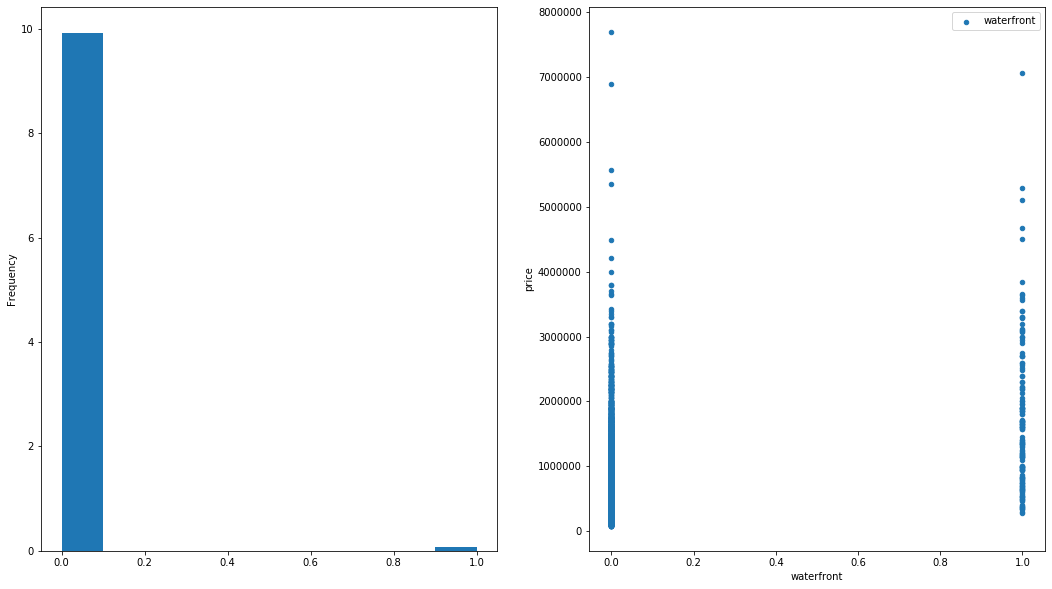

In [35]:
check_column(kc_house_newidx2, 'waterfront', 'price');

* There is a small amount of null values here, but it is evident (per the scatter plot) that there may be some influence on the price if this variable is set to one. My strategy will be to randomly sample and fill these null values because I do not want to drop roughly 10% of my data.

In [36]:
#creating copy to manipulate
dummyColumn = kc_house_newidx2['waterfront'].copy()

#boolean column indicating if item is a NA or not
nullwater = dummyColumn.isna()

#setting the sampling of values to those True-valued indices in dummyColumn
dummyColumn.loc[nullwater] = dummyColumn.dropna().sample(nullwater.sum()).values

#finalizing it
kc_house_newidx2['waterfront'] = dummyColumn.copy()

DataType:
	 float64
Null Values Present = 0


count    21419.000
mean         0.008
std          0.087
min          0.000
25%          0.000
50%          0.000
75%          0.000
max          1.000
Name: waterfront, dtype: float64


Value Counts:


0.0    21255
1.0      164
Name: waterfront, dtype: int64


Correlation:


0.25

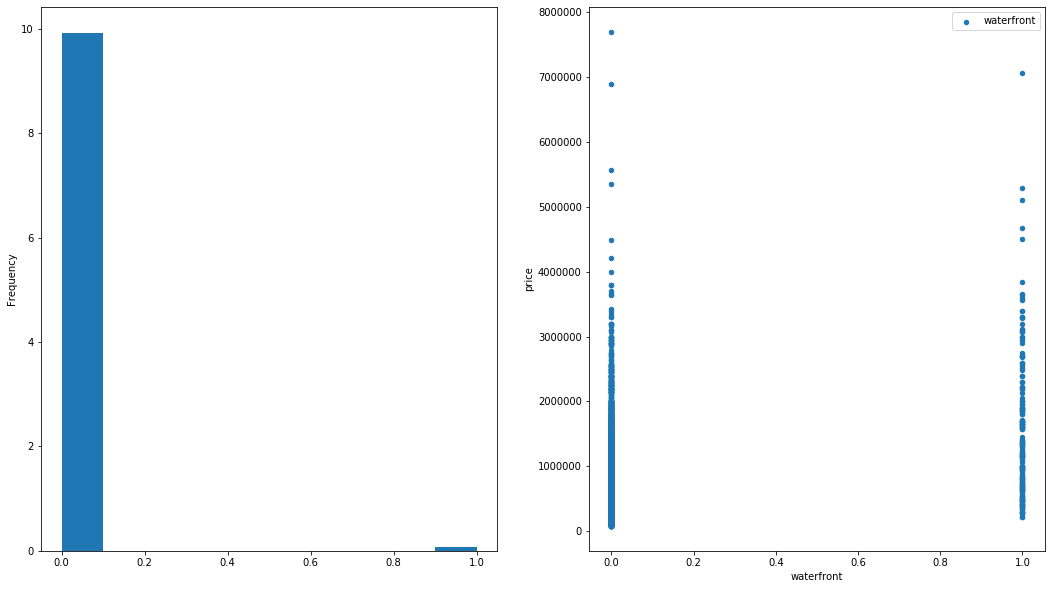

In [37]:
check_column(kc_house_newidx2, 'waterfront', 'price');

> #### A little better!

### 'View'

In [38]:
kc_house_newidx2.drop('view', axis=1, inplace=True)

> I have decided to drop the 'view' column for the same reasons I have dropped 'id' and 'date'. This variable only lets me know how many times the home was viewed before sold. Looking at the scatter plot on this data in the scatter matrix, there is no clear trend to base off of either.

### 'Condition'

DataType:
	 int64
Null Values Present = 0


count    21419.000
mean         3.411
std          0.650
min          1.000
25%          3.000
50%          3.000
75%          4.000
max          5.000
Name: condition, dtype: float64


Value Counts:


3    13900
4     5643
5     1686
2      162
1       28
Name: condition, dtype: int64


Correlation:


0.03

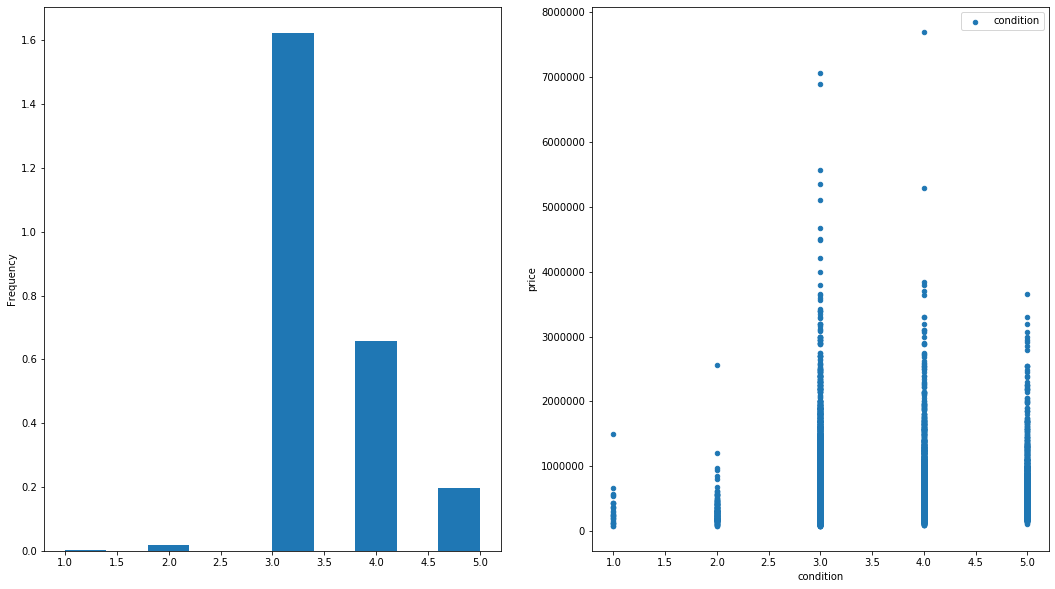

In [39]:
check_column(kc_house_newidx2, 'condition', 'price');

> This is an ordinal category and thus carries some influence on the price as the condition value gets higher. This is evidenced in the scatter plot. I will split this into dummy variables per each condition since there are not too many of them.

### 'Grade'

DataType:
	 int64
Null Values Present = 0


count    21419.000
mean         7.663
std          1.172
min          3.000
25%          7.000
50%          7.000
75%          8.000
max         13.000
Name: grade, dtype: float64


Value Counts:


7     8888
8     6041
9     2606
6     1995
10    1130
Name: grade, dtype: int64


Correlation:


0.67

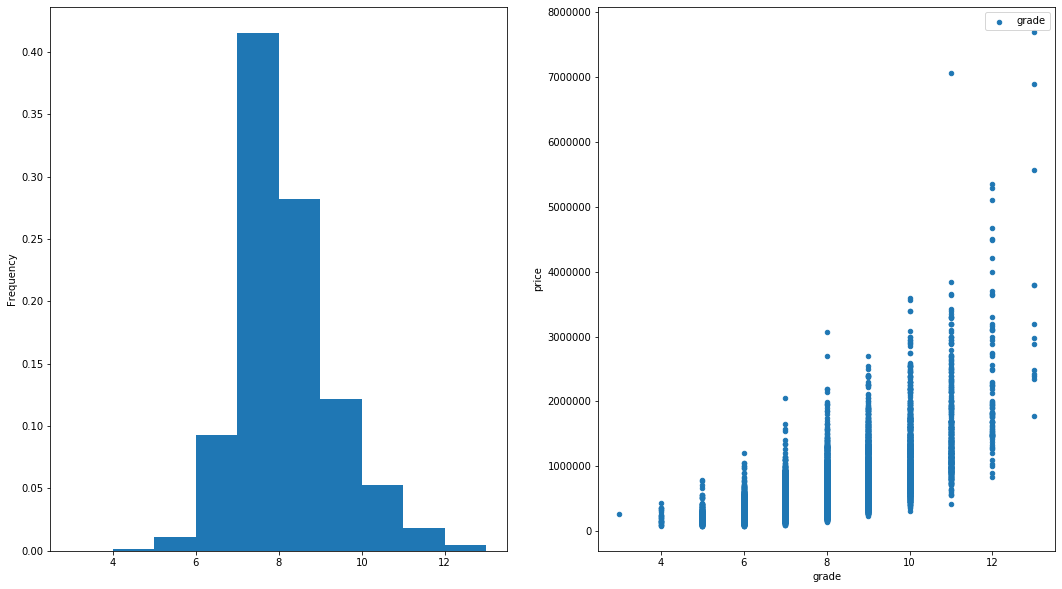

In [40]:
check_column(kc_house_newidx2, 'grade', 'price');

> This is an almost-normal, ordinal category! I will split this into bins and further create dummy variables to help include this in the model since it carries such a strong correlation with price.

### 'Sqft_above'

DataType:
	 int64
Null Values Present = 0


count    21419.000
mean      1791.205
std        828.696
min        370.000
25%       1200.000
50%       1560.000
75%       2220.000
max       9410.000
Name: sqft_above, dtype: float64


Value Counts:


1300    210
1010    204
1200    203
1220    186
1140    183
Name: sqft_above, dtype: int64


Correlation:


0.61

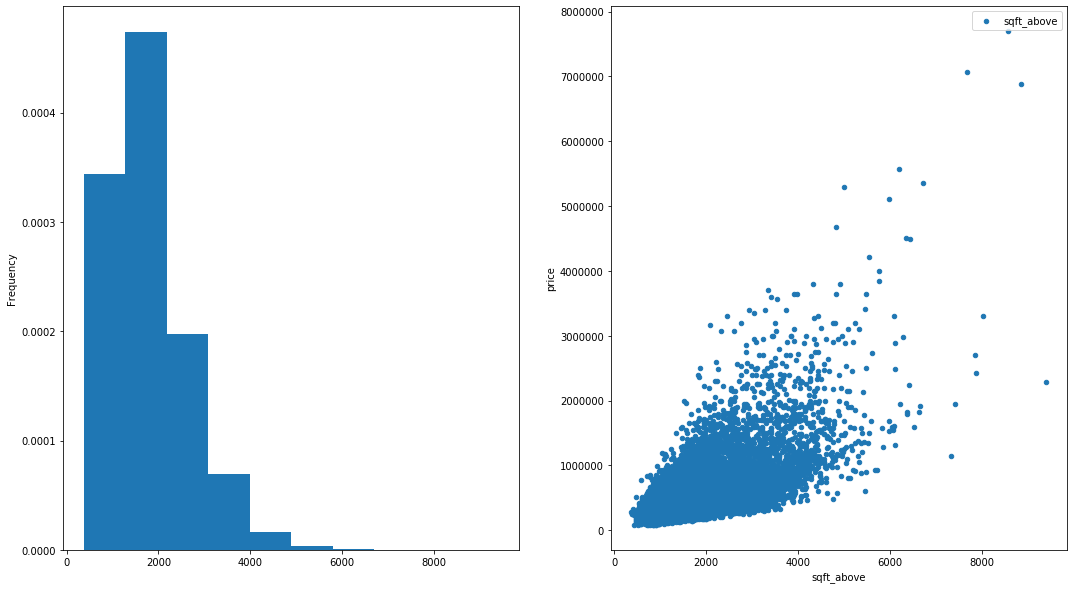

In [41]:
check_column(kc_house_newidx2, 'sqft_above', 'price');

> This has less of a correlation than the sqft_living variable and describes almost the same thing. Also has a right skew and will require a log or dropping of outliers. May drop completely due to collinearity.

### 'Sqft_basement'

* After getting an error on check_column(), I found this column carries a placeholder of '?' and has a dtype of 'object'

* This needs to be changed to a number before manipulation. My plan is to split the values of those homes under the ? category into single and multi-leveled homes. Those multi-leveled homes will get the median value input while the remaining getting 0 input.

In [42]:
kc_house_newidx2['sqft_basement'].value_counts().head()

0.0      12717
?          452
600.0      216
500.0      206
700.0      205
Name: sqft_basement, dtype: int64

In [43]:
#setting target columns to a copied df to manipulate
dummyDf = kc_house_newidx2[['sqft_basement', 'floors']].copy()

#just multi-leveled homes with a placeholder
basemcol = dummyDf[(dummyDf['sqft_basement'] == '?') & (dummyDf['floors'] > 1)].copy()

#dropping floors to access target only
basemcol = basemcol['sqft_basement']

#replacement of placeholder
basemcol.replace(to_replace='?', value='292', inplace=True)

#same as above but for single-leveled homes
basemcol2 = dummyDf[(dummyDf['sqft_basement'] == '?') & (dummyDf['floors'] <= 1)].copy()
basemcol2 = basemcol2['sqft_basement']
basemcol2.replace(to_replace='?', value='0', inplace=True)

#combining the two columns into one
basemcol_comb = pd.concat([basemcol, basemcol2])

In [44]:
#updating 'sqft_basement' column with new values
kc_house_newidx2.update(basemcol_comb)

In [45]:
#setting new column into df as a float dtype
kc_house_newidx2['sqft_basement'] = kc_house_newidx2['sqft_basement'].astype('float64', copy=False)

DataType:
	 float64
Null Values Present = 0


count    21419.000
mean       289.108
std        438.978
min          0.000
25%          0.000
50%          0.000
75%        550.000
max       4820.000
Name: sqft_basement, dtype: float64


Value Counts:


0.0      12933
292.0      236
600.0      216
500.0      206
700.0      205
Name: sqft_basement, dtype: int64


Correlation:


0.32

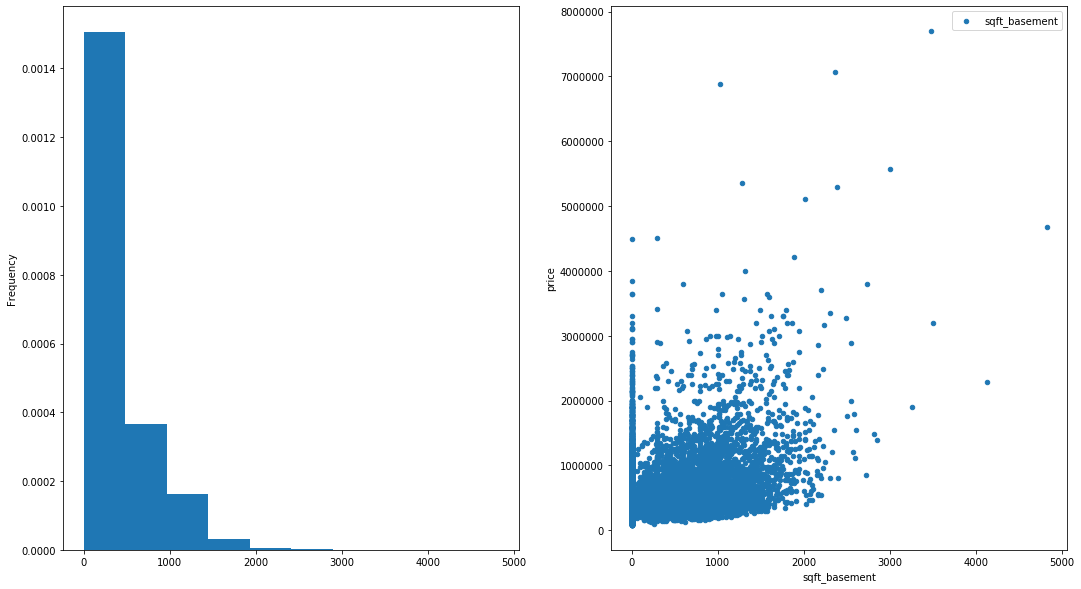

In [46]:
check_column(kc_house_newidx2, 'sqft_basement', 'price');

> There is a weak correlation that is visible via the scatter plot, but it is also very obvious that a strong skew is being caused due to over half of the data being a 0. May try to standardize and will be a potential candidate for dropping.

### 'Yr_built'

DataType:
	 int64
Null Values Present = 0


count    21419.000
mean      1971.094
std         29.387
min       1900.000
25%       1952.000
50%       1975.000
75%       1997.000
max       2015.000
Name: yr_built, dtype: float64


Value Counts:


2014    559
2006    453
2005    450
2004    429
2003    420
Name: yr_built, dtype: int64


Correlation:


0.05

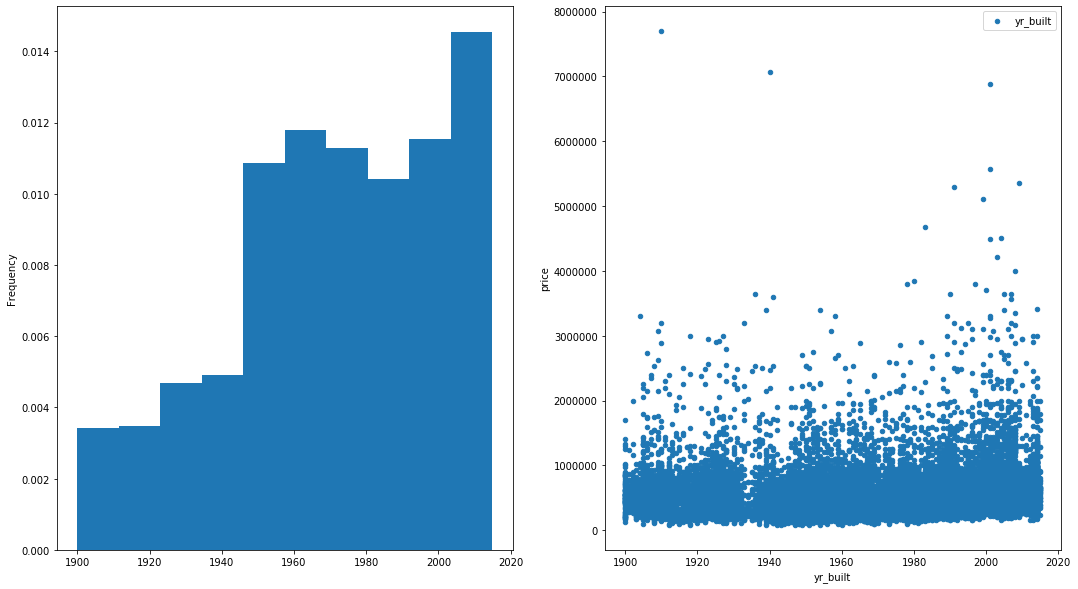

In [47]:
check_column(kc_house_newidx2, 'yr_built', 'price');

> This is an interesting feature. There appears visually to be no real correlation between the year a home was built, and the price of a home. Due to this, I may choose to drop this one in order to trim down the number of features in my model. I will more than likely split the category in half (pre vs post 1975) just to see if this will have an influence, although I doubt it.

### 'Yr_renovated'

DataType:
	 float64
Null Values Present = 3804


count    17615.000
mean        83.852
std        400.447
min          0.000
25%          0.000
50%          0.000
75%          0.000
max       2015.000
Name: yr_renovated, dtype: float64


Value Counts:


0.0       16875
2014.0       73
2003.0       31
2013.0       31
2007.0       30
Name: yr_renovated, dtype: int64


Correlation:


nan

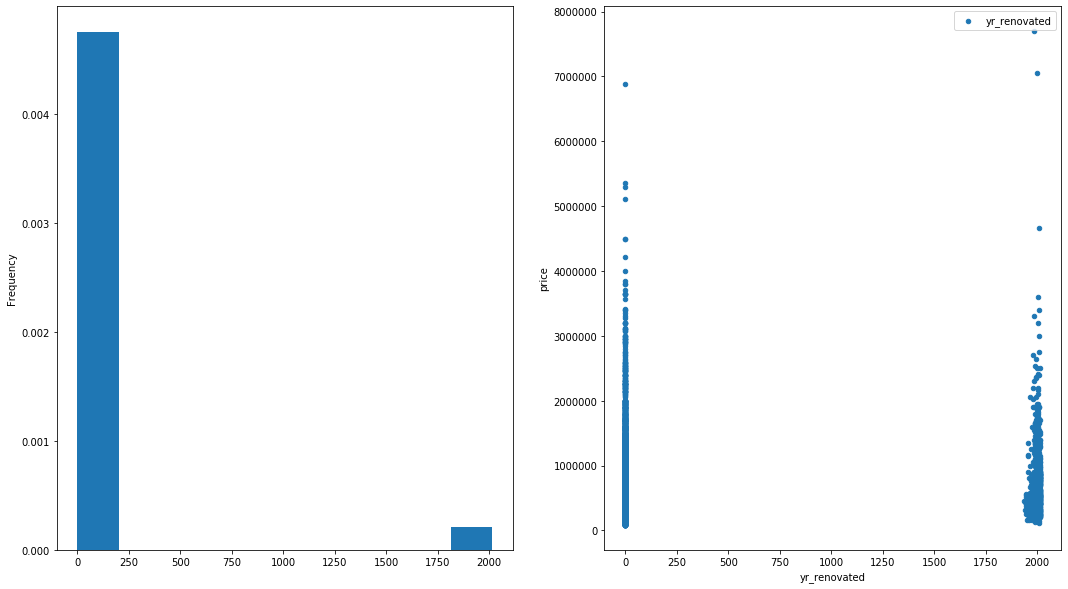

In [48]:
check_column(kc_house_newidx2, 'yr_renovated', 'price');

> By appearance, there is not much correlation between house price and date of the renovations done on the home. Additionally, approximately 17.7% of the data is null and of the remaining data 96% has the value of 0. There is not enough indication that this bears any weight on the price to keep it around. I will drop it. 

In [49]:
kc_house_newidx2 = kc_house_newidx2.drop('yr_renovated', axis=1)

### 'Zipcode'

DataType:
	 int64
Null Values Present = 0


count    21419.000
mean     98077.873
std         53.478
min      98001.000
25%      98033.000
50%      98065.000
75%      98117.000
max      98199.000
Name: zipcode, dtype: float64


Value Counts:


98103    599
98038    586
98115    576
98052    571
98117    548
Name: zipcode, dtype: int64


Correlation:


-0.05

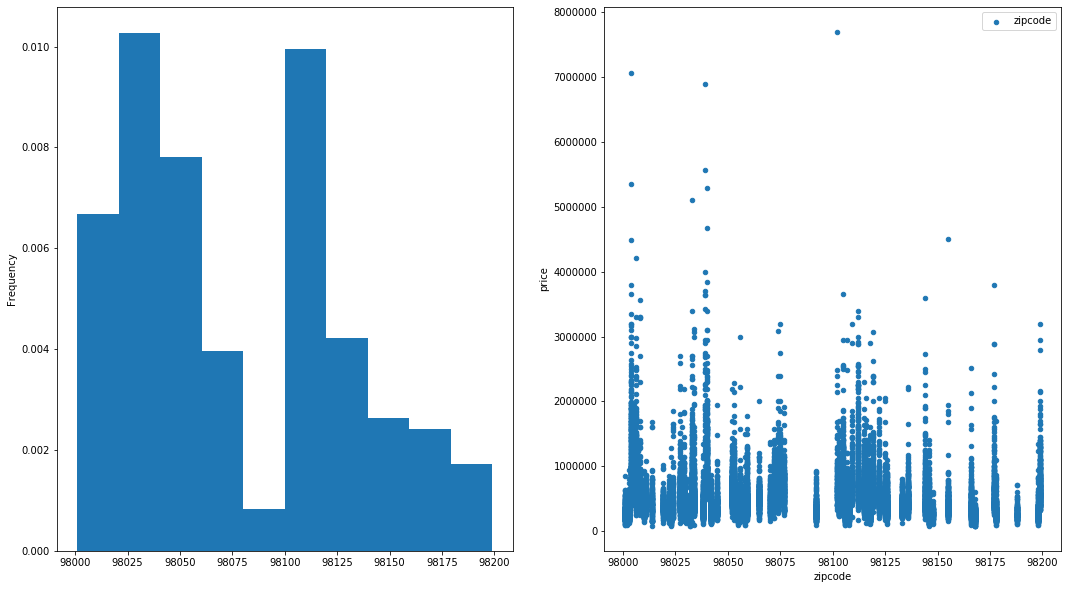

In [50]:
check_column(kc_house_newidx2, 'zipcode', 'price');

> Visually, it does not seem that zipcode alone provides a lot of influence on the price of a home. However, I can tell that some zipcodes do not have a high maximum value for price. I will split these into dummy columns, despite running into a large number of features because of it. King County includes more than Seattle, so I may be able to bin them into 'City' zipcode bins.

### 'Lat'

DataType:
	 float64
Null Values Present = 0


count    21419.000
mean        47.560
std          0.139
min         47.156
25%         47.471
50%         47.572
75%         47.678
max         47.778
Name: lat, dtype: float64


Value Counts:


47.6624    17
47.5322    17
47.5491    17
47.6846    17
47.6711    16
Name: lat, dtype: int64


Correlation:


0.31

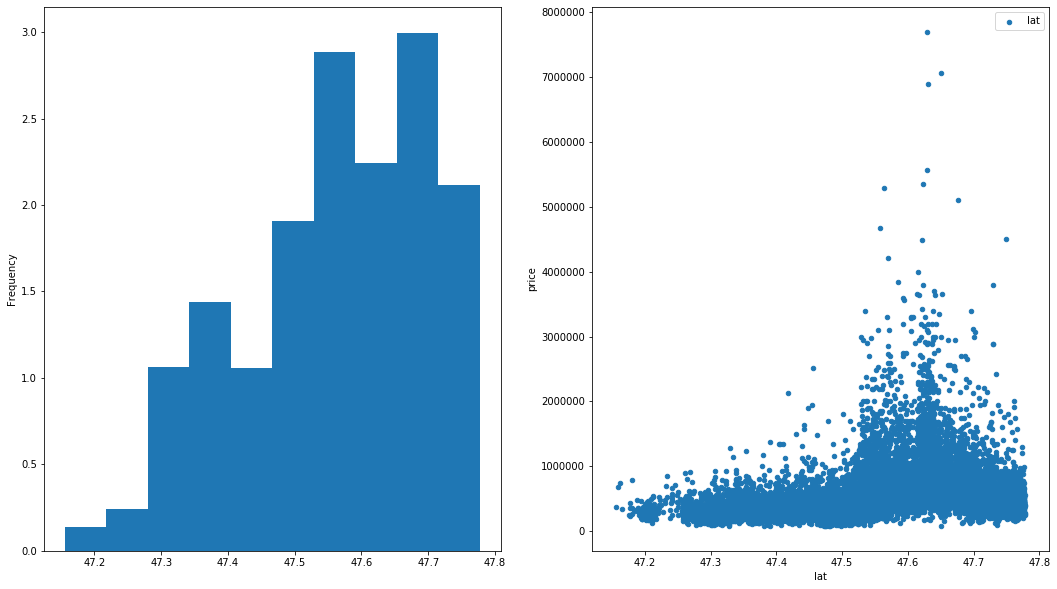

In [51]:
check_column(kc_house_newidx2, 'lat', 'price');

> This has a similar setup to the zipcode data, but in a less categorical manner. I will have to choose between which to include because I will expect some collinearity. More than likely will drop this because some of my online research shows that it is not useful unless put into a category, which zipcode is already neatly done for me. Additionally, latitude and longitude need to be as precise as possible to work (no rounding).

In [52]:
kc_house_newidx2 = kc_house_newidx2.drop('lat', axis=1)

### 'Long'

DataType:
	 float64
Null Values Present = 0


count    21419.000
mean      -122.214
std          0.141
min       -122.519
25%       -122.328
50%       -122.230
75%       -122.125
max       -121.315
Name: long, dtype: float64


Value Counts:


-122.290    113
-122.300    110
-122.362    102
-122.291    100
-122.363     99
Name: long, dtype: int64


Correlation:


0.02

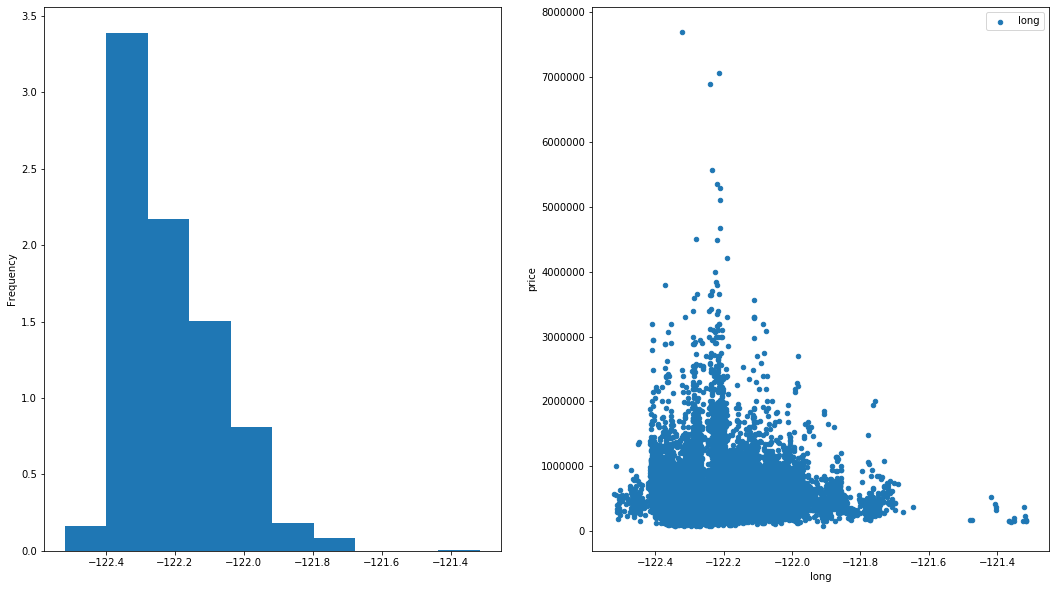

In [53]:
check_column(kc_house_newidx2, 'long', 'price');

> Less evident that longitude affects price like the latitude does, but for similar reasons, I will drop this variable. Normally the two are used in conjunction as well to plot points on a map. This will not be very useful for my regression model.

In [54]:
kc_house_newidx2 = kc_house_newidx2.drop('long', axis=1)

### 'Sqft_living15'

DataType:
	 int64
Null Values Present = 0


count    21419.000
mean      1988.415
std        685.538
min        399.000
25%       1490.000
50%       1840.000
75%       2370.000
max       6210.000
Name: sqft_living15, dtype: float64


Value Counts:


1540    193
1560    190
1440    190
1500    178
1460    168
Name: sqft_living15, dtype: int64


Correlation:


0.58

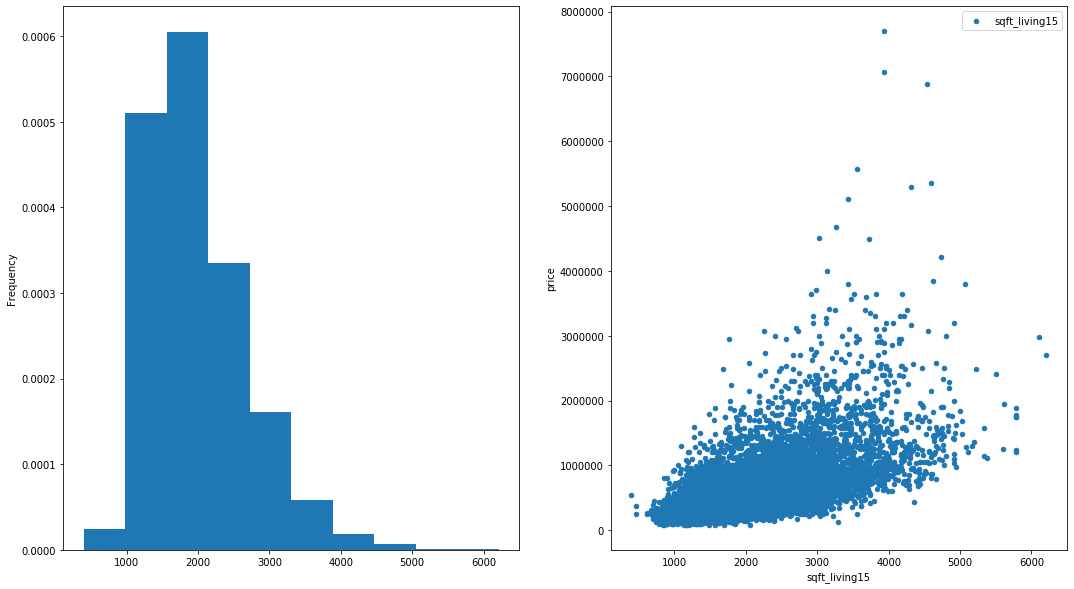

In [55]:
check_column(kc_house_newidx2, 'sqft_living15', 'price');

> Looks very similar to the other square footage variables. I will need to keep one or more of them for sure, this will be a drop candidate due to the nature of what the variable itself captures. 

### 'Sqft_lot15'

DataType:
	 int64
Null Values Present = 0


count     21419.000
mean      12776.095
std       27346.205
min         651.000
25%        5100.000
50%        7620.000
75%       10086.500
max      871200.000
Name: sqft_lot15, dtype: float64


Value Counts:


5000    425
4000    354
6000    285
7200    209
4800    144
Name: sqft_lot15, dtype: int64


Correlation:


0.08

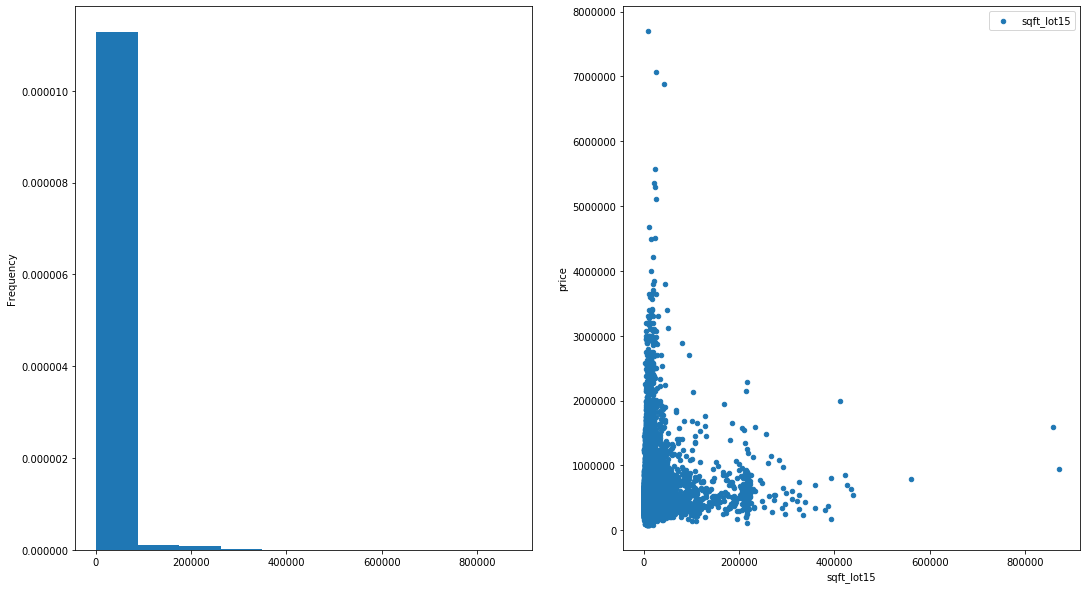

In [56]:
check_column(kc_house_newidx2, 'sqft_lot15', 'price');

> This one is even more skewed than the other lot variable and would need to have outliers dropped in order to be viable. Strong drop candidate.

### Finally removing 'id'

> Now that I have looked over all of the columns, I will drop the 'id' column that I was using as a way to ensure I have unique homes within the data set.

In [57]:
kc_house_newidx2 = kc_house_newidx2.drop('id', axis=1)

## Removing the outliers

In [58]:
#This will use the stats.zscore() to grab all abs(zscores) less than 3
    #and place them in a separate df
kc_no_outlier = kc_house_newidx2[(np.abs(stats.zscore(kc_house_newidx2)) < 3).all(axis=1)]

In [59]:
#need to reset index
kc_no_outlier = kc_no_outlier.reset_index(drop=True)
kc_no_outlier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19925 entries, 0 to 19924
Data columns (total 15 columns):
price            19925 non-null float64
bedrooms         19925 non-null int64
bathrooms        19925 non-null float64
sqft_living      19925 non-null int64
sqft_lot         19925 non-null int64
floors           19925 non-null float64
waterfront       19925 non-null float64
condition        19925 non-null int64
grade            19925 non-null int64
sqft_above       19925 non-null int64
sqft_basement    19925 non-null float64
yr_built         19925 non-null int64
zipcode          19925 non-null int64
sqft_living15    19925 non-null int64
sqft_lot15       19925 non-null int64
dtypes: float64(5), int64(10)
memory usage: 2.3 MB


## Heatmap check for collinearity

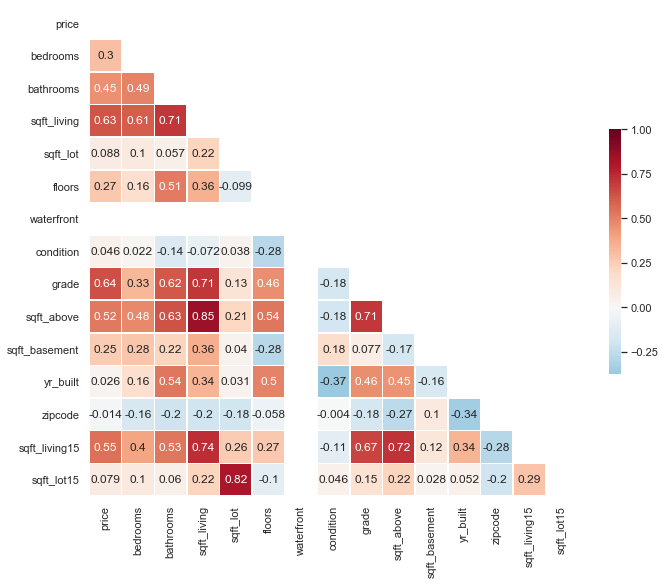

In [60]:
sns.set(style="white")

#Grabbing the correlation matrix
corr = kc_no_outlier.corr()

#Making a mask
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

#Setting the figure
fig, ax = plt.subplots(figsize=(11, 9))

#Generate the heatmap
sns.heatmap(corr, mask=mask, cmap='RdBu_r', vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True);

> Looking at the heatmap, there are high collinearity between:

* SQFT_LIVING & SQFT_ABOVE (0.85) & GRADE (0.71) & SQFT_LIVING15 (0.74) & BATHROOMS (0.71)
* SQFT_LOT & SQFT_LOT15 (0.82)
* SQFT_LIVING15 & SQFT_ABOVE (0.72)
* SQFT_ABOVE & GRADE (0.71)

> Price the target variable, shows collinearity with:

* SQFT_LIVING (0.63)
* GRADE (0.64)

> I will drop both of the sqft...15 features since they show high collinearity with the other sqft features and lot15 has a lower correlation with price than the sqft_lot does. Sqft_above will be dropped for similar reasoning as with sqft_lot15.

In [61]:
kc_no_outlier.drop(['sqft_living15', 'sqft_lot15', 'sqft_above'], axis=1, inplace=True)

In [62]:
#kc_no_outlier.drop('sqft_above', axis=1, inplace=True)

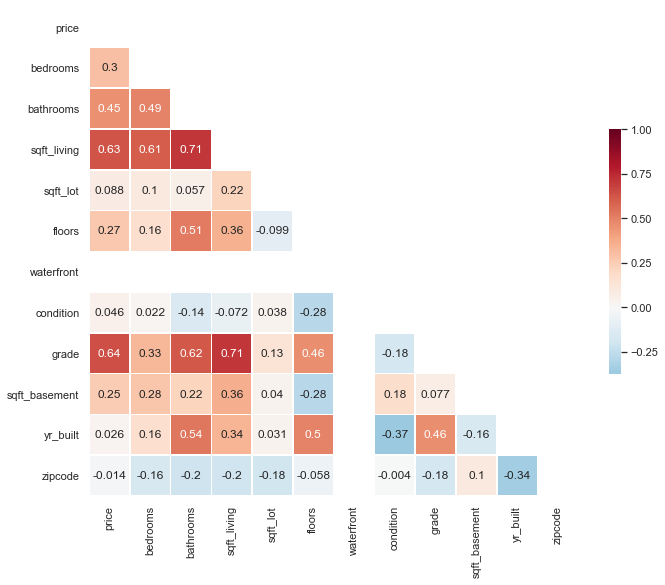

In [63]:
#Grabbing the correlation matrix
corr2 = kc_no_outlier.corr()

#Making a mask
mask = np.zeros_like(corr2, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

#Setting the figure
fig, ax = plt.subplots(figsize=(11, 9))

#Generate the heatmap
sns.heatmap(corr2, mask=mask, cmap='RdBu_r', vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True);

> For right now I will leave the remaining hotspots in as none are beyond my threshold of 0.75 and may still provide good information.

## Creating dummy columns

#### Floors

In [64]:
#creating a series of binary values to put into bins easier
flrs_binary = pd.Series([])
for idx, item in zip(list(range(0, len(kc_no_outlier['floors']))), kc_no_outlier['floors']):
    if item < 1.5:
        flrs_binary[idx] = 0
    else:
        flrs_binary[idx] = 1  

In [65]:
bins = [0, 0.5, 1]
bins_flrs = pd.cut(flrs_binary, bins)
bins_flrs = bins_flrs.cat.as_unordered()
flrs_dummy = pd.get_dummies(bins_flrs, prefix='flrs', drop_first=True)
            #len(flrs_dummy)

In [66]:
kc_no_outlier = kc_no_outlier.drop('floors', axis=1)
kc_no_outlier = pd.concat([kc_no_outlier, flrs_dummy], axis=1)

***************

> * At this point I will have two different iterations of the same dataset. **kc_no_outlier** will represent my __original__ attempt at the model. **kc_no_out2** will represent my __revisional__ changes for my model.

In [67]:
kc_no_out2 = kc_no_outlier.copy()

*********************

#### Condition

In [68]:
bins = [0, 1, 2, 3, 4, 5]
bins_cond = pd.cut(kc_no_outlier['condition'], bins)
bins_cond = bins_cond.cat.as_unordered()
cond_dummy = pd.get_dummies(bins_cond, prefix='cond', drop_first=True)
            #len(cond_dummy)

In [69]:
kc_no_outlier = kc_no_outlier.drop('condition', axis=1)
kc_no_outlier = pd.concat([kc_no_outlier, cond_dummy], axis=1)

**************************

> * I will be leaving condition un-binned for _kc_no_out2_

#### Yr_built

In [70]:
bins = [0, 1975, 2016]
bins_yrbuilt = pd.cut(kc_no_outlier['yr_built'], bins)
bins_yrbuilt = bins_yrbuilt.cat.as_unordered()
yrbuilt_dummy = pd.get_dummies(bins_yrbuilt, prefix='yr_built', drop_first=True)
            #len(yrbuilt_dummy)

In [71]:
kc_no_outlier = kc_no_outlier.drop('yr_built', axis=1)
kc_no_outlier = pd.concat([kc_no_outlier, yrbuilt_dummy], axis=1)

***************************

In [72]:
#same as above

bins = [0, 1975, 2016]
bins_yrbuilt = pd.cut(kc_no_out2['yr_built'], bins)
bins_yrbuilt = bins_yrbuilt.cat.as_unordered()
yrbuilt_dummy = pd.get_dummies(bins_yrbuilt, prefix='yr_built', drop_first=True)

In [73]:
kc_no_out2 = kc_no_out2.drop('yr_built', axis=1)
kc_no_out2 = pd.concat([kc_no_out2, yrbuilt_dummy], axis=1)

#### Zipcode

In [74]:
#creating a list of unique zipcodes to use as bins
ziplist = list(kc_no_outlier['zipcode'].unique())
bins = [0]
bins.extend(ziplist)
bins = sorted(bins)

bins_zipC = pd.cut(kc_no_outlier['zipcode'], bins)
bins_zipC = bins_zipC.cat.as_unordered()
zipC_dummy = pd.get_dummies(bins_zipC, prefix='zipcode', drop_first=True)
            #len(zipC_dummy)

In [75]:
kc_no_outlier = kc_no_outlier.drop('zipcode', axis=1)
kc_no_outlier = pd.concat([kc_no_outlier, zipC_dummy], axis=1)

**************************

In [76]:
#creating dummies without binning
zipC_dummy = pd.get_dummies(kc_no_out2['zipcode'], prefix='zipcode', drop_first=True)

#assigning to df
kc_no_out2 = kc_no_out2.drop('zipcode', axis=1)
kc_no_out2 = pd.concat([kc_no_out2, zipC_dummy], axis=1)

### Final-_ish_ Check

In [77]:
kc_no_outlier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19925 entries, 0 to 19924
Data columns (total 83 columns):
price                     19925 non-null float64
bedrooms                  19925 non-null int64
bathrooms                 19925 non-null float64
sqft_living               19925 non-null int64
sqft_lot                  19925 non-null int64
waterfront                19925 non-null float64
grade                     19925 non-null int64
sqft_basement             19925 non-null float64
flrs_(0.5, 1.0]           19925 non-null uint8
cond_(1, 2]               19925 non-null uint8
cond_(2, 3]               19925 non-null uint8
cond_(3, 4]               19925 non-null uint8
cond_(4, 5]               19925 non-null uint8
yr_built_(1975, 2016]     19925 non-null uint8
zipcode_(98001, 98002]    19925 non-null uint8
zipcode_(98002, 98003]    19925 non-null uint8
zipcode_(98003, 98004]    19925 non-null uint8
zipcode_(98004, 98005]    19925 non-null uint8
zipcode_(98005, 98006]    19925 non-n

In [78]:
kc_no_out2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19925 entries, 0 to 19924
Data columns (total 80 columns):
price                    19925 non-null float64
bedrooms                 19925 non-null int64
bathrooms                19925 non-null float64
sqft_living              19925 non-null int64
sqft_lot                 19925 non-null int64
waterfront               19925 non-null float64
condition                19925 non-null int64
grade                    19925 non-null int64
sqft_basement            19925 non-null float64
flrs_(0.5, 1.0]          19925 non-null uint8
yr_built_(1975, 2016]    19925 non-null uint8
zipcode_98002            19925 non-null uint8
zipcode_98003            19925 non-null uint8
zipcode_98004            19925 non-null uint8
zipcode_98005            19925 non-null uint8
zipcode_98006            19925 non-null uint8
zipcode_98007            19925 non-null uint8
zipcode_98008            19925 non-null uint8
zipcode_98010            19925 non-null uint8
zipcode_9

# EXPLORE

### Dealing with collinearity

> Now I will begin playing with the distributions to get something I feel comfortable with modeling. I will first split off the price variable into it's own series, leaving the remaining dataframe as my 'features'.

In [79]:
#one for each
price_series = kc_no_outlier['price'].copy()
price_series2 = kc_no_out2['price'].copy()

In [80]:
kc_house_feat1 = kc_no_outlier.drop('price', axis=1).copy()
kc_house_feat1_2 = kc_no_out2.drop('price', axis=1).copy()

In [81]:
corr3 = np.abs(kc_house_feat1.corr().round(3))
corr3_2 = np.abs(kc_house_feat1_2.corr().round(3))

In [82]:
#corr3[corr3 > 0.75]     #this was really large

(corr3[abs(corr3 > 0.75)].sum() > 1).value_counts()

False    80
True      2
dtype: int64

****************

In [83]:
(corr3_2[abs(corr3_2 > 0.75)].sum() > 1).value_counts()

False    79
dtype: int64

> COND_(2, 3] & COND_(3, 4] have collinearity, but I will keep for now since they came from the same category

> For the above, I looked at a very large dataframe that had a bunch of NaN values. To remedy this, I looked at a boolean series of the columns indicating which had a correlation greater than 0.75 with another column. This was acheived by asking python to return those columns with a sum of the non-null correlation values greater than 1 (every column has 1 due to matching with itself).

> Then I used the .value_counts() method to count up how many columns I need to target, since Jupyter did not display _every_ column in the dataframe.

* #### These columns are: 

>'cond_(2, 3]' , 'cond_(3, 4]'. 

* I will not remove one of these since I have already removed the first bin. If I see anything weird with the P-values, I will adjust accordingly

In [84]:
#making it a copy for safety

kc_house_feat_nocorr = kc_house_feat1.copy()
kc_house_feat_nocorr2 = kc_house_feat1_2.copy()

### Transforming features

> I have decided to min-max scale the sqft features to allow them to be on a similar scale and not mess too much with the bed/bathroom features due to the large values within them currently.

In [86]:
#making copies for safety
no_zip_feat = kc_house_feat_nocorr[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_basement']].copy()
no_zip_feat2 = no_zip_feat.copy()

#revised df
no_zip_feat_2 = kc_house_feat_nocorr2[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_basement']].copy()
no_zip_feat2_new = no_zip_feat_2.copy()

> For my revisions I will normalize the features. I will be adding bedrooms and bathrooms to make sure __all__ of the features are within the same range. I am hoping this will increase my predictive accuracy. I am interested to see how having 'negative' bedrooms, etc. will affect the output modeling as well. 

In [87]:
tfsqftliving = minmaxscaler(no_zip_feat['sqft_living'])
tfsqftlot = minmaxscaler(no_zip_feat['sqft_lot'])
tfsqftbasement = minmaxscaler(no_zip_feat['sqft_basement'])

#revised df
tfsqftliving_2 = nrmlizer(no_zip_feat_2['sqft_living'])
tfsqftlot_2 = nrmlizer(no_zip_feat_2['sqft_lot'])
tfsqftbasement_2 = nrmlizer(no_zip_feat_2['sqft_basement'])
tfbedrooms_2 = nrmlizer(no_zip_feat_2['bedrooms'])
tfbathooms_2 = nrmlizer(no_zip_feat_2['bathrooms'])

In [88]:
no_zip_feat2['sqft_living'] = tfsqftliving.copy()
no_zip_feat2['sqft_lot'] = tfsqftlot.copy()
no_zip_feat2['sqft_basement'] = tfsqftbasement.copy()

#revised df
no_zip_feat2_new['sqft_living'] = tfsqftliving_2.copy()
no_zip_feat2_new['sqft_lot'] = tfsqftlot_2.copy()
no_zip_feat2_new['sqft_basement'] = tfsqftbasement_2.copy()
no_zip_feat2_new['bedrooms'] = tfbedrooms_2.copy()
no_zip_feat2_new['bathrooms'] = tfbathooms_2.copy()

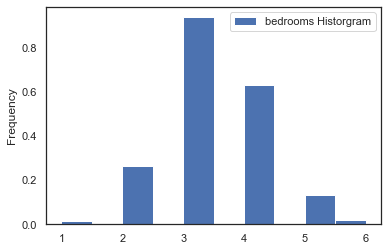

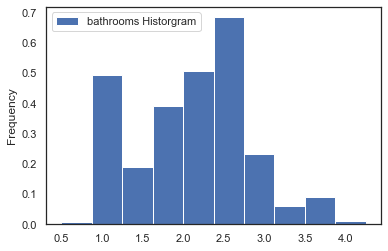

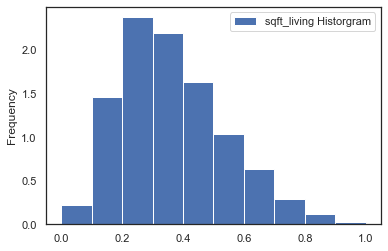

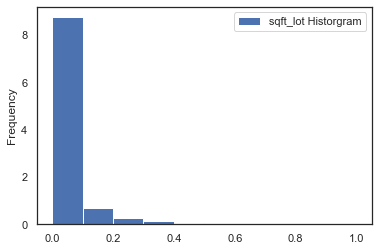

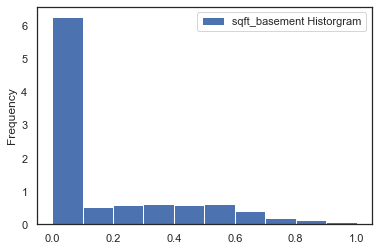

In [89]:
kde_hist_plot(no_zip_feat2)
#for column in no_zip_feat2:
#    print(no_zip_feat2[column].describe().round(3))

> Since the sqft basement and lot are still highly skewed, I may drop them if this model doesn't quite work out.

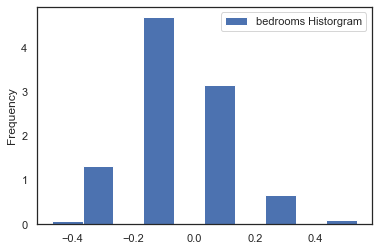

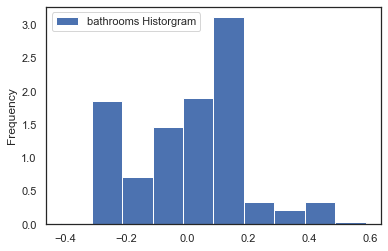

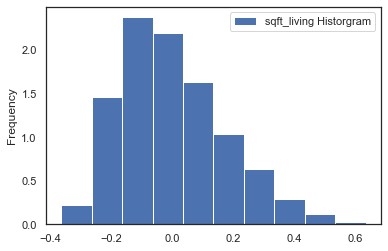

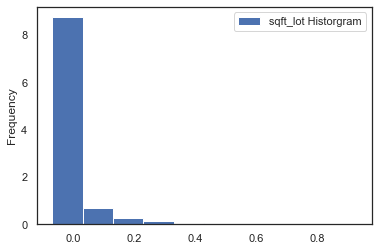

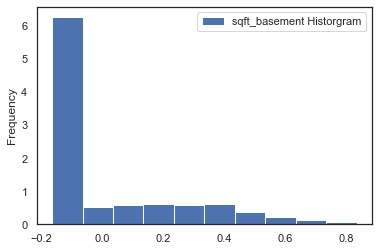

In [90]:
kde_hist_plot(no_zip_feat2_new)

> Visually, the revision of normalization hasn't changed much on the corresponding features. 

In [92]:
#updating the min-maxed columns in 'no_corr' dataframe
kc_house_feat_nocorr.update(no_zip_feat2)
kc_house_feat_nocorr2.update(no_zip_feat2_new)

#sanity check
print(no_zip_feat2['sqft_living'].describe() == kc_house_feat_nocorr['sqft_living'].describe())
no_zip_feat2_new['sqft_living'].describe() == kc_house_feat_nocorr2['sqft_living'].describe()

count    True
mean     True
std      True
min      True
25%      True
50%      True
75%      True
max      True
Name: sqft_living, dtype: bool


count    True
mean     True
std      True
min      True
25%      True
50%      True
75%      True
max      True
Name: sqft_living, dtype: bool

# MODEL

###### Train-test split 1

In [93]:
x = kc_house_feat_nocorr.copy()
y = pd.DataFrame(price_series)

In [94]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

In [95]:
linreg = LinearRegression()
linreg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

###### OLS

In [96]:
x_cnst_trn = sm.add_constant(x_train)
model1 = sm.OLS(y_train, x_cnst_trn).fit()
model1.summary()

C:\Users\d_ful\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     770.0
Date:                Mon, 09 Dec 2019   Prob (F-statistic):               0.00
Time:                        17:06:09   Log-Likelihood:            -1.8094e+05
No. Observations:               13947   AIC:                         3.620e+05
Df Residuals:                   13866   BIC:                         3.627e+05
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -2.722e+05   9466.914    -28.756      0.000   -2.91e+05   -2.54e+05
bedrooms               -1.102e+04   1392.416     -7.912      0.000   -1.37e+04   -8287.796
bathrooms               1.569e+04   2214.696      7.087      0.000    1.14e+04       2e+04
sqft_living             6.684e+05   1.13e+04     59.369      0.000    6.46e+05     6.9e+05
sqft_lot                1.183e+05   1.19e+04      9.965      0.000     9.5e+04    1.42e+05
waterfront              1.403e-09   3.45e-11     40.666      0.000    1.33e-09    1.47e-09
grade                   5.779e+04   1467.767     39.375      0.000    5.49e+04    6.07e+04
sqft_basement          -6.719e+04   5110.231    -13.149      0.000   -7.72e+04   -5.72e+04
flrs_(0.5, 1.0]        -1.213e+04   2609.426     -4.650      0.000   -1.72e+04   -7019.893
cond_(1, 2]            -1.007e+05   9100.880    -11.064      0.000   -1.19e+05   -8.29e+04
cond_(2, 3]            -8.369e+04   3581.974    -23.364      0.000   -9.07e+04   -7.67e+04
cond_(3, 4]            -6.338e+04   3578.620    -17.711      0.000   -7.04e+04   -5.64e+04
cond_(4, 5]            -2.447e+04   4202.311     -5.822      0.000   -3.27e+04   -1.62e+04
yr_built_(1975, 2016]  -3.683e+04   2799.248    -13.156      0.000   -4.23e+04   -3.13e+04
zipcode_(98001, 98002]  2.779e+04   1.14e+04      2.428      0.015    5352.776    5.02e+04
zipcode_(98002, 98003]   644.8292   1.02e+04      0.063      0.950   -1.94e+04    2.07e+04
zipcode_(98003, 98004]  6.015e+05    1.1e+04     54.641      0.000     5.8e+05    6.23e+05
zipcode_(98004, 98005]  3.128e+05   1.24e+04     25.316      0.000    2.89e+05    3.37e+05
zipcode_(98005, 98006]  2.803e+05   9206.965     30.446      0.000    2.62e+05    2.98e+05
zipcode_(98006, 98007]  2.506e+05   1.27e+04     19.732      0.000    2.26e+05    2.76e+05
zipcode_(98007, 98008]    2.5e+05   1.02e+04     24.399      0.000     2.3e+05     2.7e+05
zipcode_(98008, 98010]  8.185e+04   1.57e+04      5.198      0.000     5.1e+04    1.13e+05
zipcode_(98010, 98011]  1.454e+05   1.12e+04     12.959      0.000    1.23e+05    1.67e+05
zipcode_(98011, 98014]  9.482e+04   1.51e+04      6.263      0.000    6.51e+04    1.24e+05
zipcode_(98014, 98019]  1.023e+05   1.17e+04      8.736      0.000    7.93e+04    1.25e+05
zipcode_(98019, 98022]  1.341e+04   1.17e+04      1.145      0.252   -9549.282    3.64e+04
zipcode_(98022, 98023] -1.466e+04   8787.664     -1.669      0.095   -3.19e+04    2561.028
zipcode_(98023, 98024]  1.495e+05    1.9e+04      7.883      0.000    1.12e+05    1.87e+05
zipcode_(98024, 98027]  1.932e+05   9348.282     20.665      0.000    1.75e+05    2.12e+05
zipcode_(98027, 98028]  1.392e+05   1.04e+04     13.345      0.000    1.19e+05     1.6e+05
zipcode_(98028, 98029]  2.272e+05   9799.849     23.183      0.000    2.08e+05  

C:\Users\d_ful\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


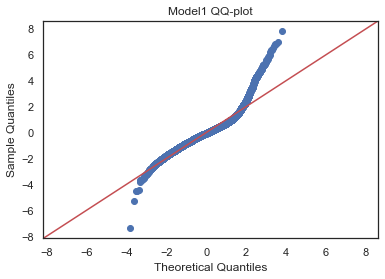

In [119]:
residuals1 = model1.resid
fig1 = sm.graphics.qqplot(residuals1, dist=stats.norm, line='45', fit=True)
plt.title('Model1 QQ-plot')
fig1.show();

* There is a clear right-tailed skew prevalent within my _model1_

> I am going to drop anything with a p-value > 0.05 and re-run

In [97]:
x = x.drop('zipcode_(98001, 98002]', axis=1).copy()
x = x.drop('zipcode_(98002, 98003]', axis=1).copy()
x = x.drop('zipcode_(98019, 98022]', axis=1).copy()
x = x.drop('zipcode_(98022, 98023]', axis=1).copy()
x = x.drop('zipcode_(98029, 98030]', axis=1).copy()
x = x.drop('zipcode_(98030, 98031]', axis=1).copy()
x = x.drop('zipcode_(98031, 98032]', axis=1).copy()
x = x.drop('zipcode_(98040, 98042]', axis=1).copy()

###### Train-test split 2

In [98]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(x, y, test_size=0.30, random_state=43)

###### OLS 2

In [99]:
x_cnst_trn2 = sm.add_constant(x_train2)
model2 = sm.OLS(y_train2, x_cnst_trn2).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     839.9
Date:                Mon, 09 Dec 2019   Prob (F-statistic):               0.00
Time:                        17:06:22   Log-Likelihood:            -1.8090e+05
No. Observations:               13947   AIC:                         3.620e+05
Df Residuals:                   13874   BIC:                         3.625e+05
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -2.61e+05   8070.004    -32.345      0.000   -2.77e+05   -2.45e+05
bedrooms               -1.025e+04   1388.444     -7.382      0.000    -1.3e+04   -7528.110
bathrooms               1.359e+04   2187.541      6.212      0.000    9300.209    1.79e+04
sqft_living             6.535e+05   1.13e+04     58.033      0.000    6.31e+05    6.76e+05
sqft_lot                1.312e+05   1.19e+04     10.986      0.000    1.08e+05    1.55e+05
waterfront             -2.415e-09   4.23e-11    -57.060      0.000    -2.5e-09   -2.33e-09
grade                   5.751e+04   1464.404     39.274      0.000    5.46e+04    6.04e+04
sqft_basement          -6.156e+04   5081.824    -12.114      0.000   -7.15e+04   -5.16e+04
flrs_(0.5, 1.0]        -6825.1080   2602.158     -2.623      0.009   -1.19e+04   -1724.527
cond_(1, 2]            -9.283e+04   8598.535    -10.796      0.000    -1.1e+05    -7.6e+04
cond_(2, 3]             -8.15e+04   3300.316    -24.696      0.000    -8.8e+04    -7.5e+04
cond_(3, 4]            -6.076e+04   3256.468    -18.660      0.000   -6.71e+04   -5.44e+04
cond_(4, 5]            -2.593e+04   3892.711     -6.661      0.000   -3.36e+04   -1.83e+04
yr_built_(1975, 2016]  -4.143e+04   2756.310    -15.033      0.000   -4.68e+04    -3.6e+04
zipcode_(98003, 98004]  6.005e+05   8800.746     68.231      0.000    5.83e+05    6.18e+05
zipcode_(98004, 98005]  3.141e+05   1.11e+04     28.217      0.000    2.92e+05    3.36e+05
zipcode_(98005, 98006]  2.758e+05   6701.463     41.157      0.000    2.63e+05    2.89e+05
zipcode_(98006, 98007]  2.468e+05   1.09e+04     22.605      0.000    2.25e+05    2.68e+05
zipcode_(98007, 98008]  2.408e+05   7976.415     30.188      0.000    2.25e+05    2.56e+05
zipcode_(98008, 98010]  7.541e+04   1.41e+04      5.363      0.000    4.78e+04    1.03e+05
zipcode_(98010, 98011]  1.365e+05   9623.263     14.179      0.000    1.18e+05    1.55e+05
zipcode_(98011, 98014]  1.072e+05   1.34e+04      8.026      0.000     8.1e+04    1.33e+05
zipcode_(98014, 98019]  9.208e+04   9876.244      9.324      0.000    7.27e+04    1.11e+05
zipcode_(98023, 98024]  1.445e+05   1.81e+04      7.977      0.000    1.09e+05     1.8e+05
zipcode_(98024, 98027]  1.843e+05   7040.860     26.177      0.000    1.71e+05    1.98e+05
zipcode_(98027, 98028]  1.315e+05   7784.467     16.891      0.000    1.16e+05    1.47e+05
zipcode_(98028, 98029]  2.222e+05   7534.195     29.489      0.000    2.07e+05    2.37e+05
zipcode_(98032, 98033]  3.499e+05   6916.088     50.593      0.000    3.36e+05    3.63e+05
zipcode_(98033, 98034]  1.892e+05   6051.058     31.260      0.000    1.77e+05    2.01e+05
zipcode_(98034, 98038]  3.555e+04   6042.130      5.884      0.000    2.37e+04    4.74e+04
zipcode_(98038, 98039]  8.131e+05   3.16e+04     25.763      0.000    7.51e+05  

C:\Users\d_ful\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


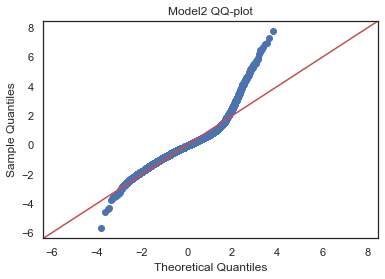

In [120]:
residuals2 = model2.resid
fig2 = sm.graphics.qqplot(residuals2, dist=stats.norm, line='45', fit=True)
plt.title('Model2 QQ-plot')
fig2.show();

> I want to take a look at the MSE for this model, since all of the coefficients fall within our threshold of 0.05 p-value (the closest is 'FLRS_(0.5, 1.0]' at 0.019)

In [100]:
linreg.fit(x_train2, y_train2)

y_hat_train2 = linreg.predict(x_train2)
y_hat_test2 = linreg.predict(x_test2)

In [101]:
test2_resid = y_hat_test2 - y_test2
train2_resid = y_hat_train2 - y_train2

In [102]:
test2_mse = mean_squared_error(y_test2, y_hat_test2)
train2_mse = mean_squared_error(y_train2, y_hat_train2)

In [103]:
print(test2_mse, train2_mse)

11650556325.241385 10810424178.098965


> In this case, the MSE isn't telling me too much since it is the _squared_ error against prices in the 100s of thousands of dollars. If I square root these numbers I get (respectively): [104,783.47 & 105,335.00]. This means that the difference of prediction error isn't too different and actually better on the test data. 

* Due to the negligible difference in R-squared between the two models, I will go with model1. I will check the MSE just to make sure it translates to test, and therefore other, data with the same predictability.

In [104]:
linreg.fit(x_train, y_train)

y_hat_train1 = linreg.predict(x_train)
y_hat_test1 = linreg.predict(x_test)

In [105]:
test1_resid = y_hat_test1 - y_test
train1_resid = y_hat_train1 - y_train

In [106]:
test1_mse = mean_squared_error(y_test, y_hat_test1)
train1_mse = mean_squared_error(y_train, y_hat_train1)

In [107]:
print(test1_mse, train1_mse)

11445545357.753975 10864118271.325392


> This has almost identical MSEs of (respectively): [105,059.56 & 105,089.41]

## Revised modeling

In [112]:
#setting variables
x = kc_house_feat_nocorr2.copy()
y = pd.DataFrame(price_series2)

In [113]:
#t-t split
x_train3, x_test3, y_train3, y_test3 = train_test_split(x, y, test_size=0.30, random_state=42)

In [116]:
x_cnst_trn3 = sm.add_constant(x_train3)
model3 = sm.OLS(y_train3, x_cnst_trn3).fit()
model3.summary()

C:\Users\d_ful\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     788.8
Date:                Mon, 09 Dec 2019   Prob (F-statistic):               0.00
Time:                        17:14:08   Log-Likelihood:            -1.8095e+05
No. Observations:               13947   AIC:                         3.621e+05
Df Residuals:                   13868   BIC:                         3.626e+05
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.981e+05   1.39e+04    -14.227      0.000   -2.25e+05   -1.71e+05
bedrooms              -5.545e+04   6963.980     -7.963      0.000   -6.91e+04   -4.18e+04
bathrooms              6.069e+04   8294.357      7.317      0.000    4.44e+04    7.69e+04
sqft_living            6.684e+05   1.13e+04     59.343      0.000    6.46e+05     6.9e+05
sqft_lot               1.171e+05   1.18e+04      9.889      0.000    9.39e+04     1.4e+05
waterfront            -2.739e-09   1.06e-10    -25.889      0.000   -2.95e-09   -2.53e-09
condition              2.602e+04   1559.528     16.685      0.000     2.3e+04    2.91e+04
grade                  5.776e+04   1466.285     39.393      0.000    5.49e+04    6.06e+04
sqft_basement         -6.739e+04   5112.338    -13.183      0.000   -7.74e+04   -5.74e+04
flrs_(0.5, 1.0]        -1.18e+04   2608.919     -4.523      0.000   -1.69e+04   -6687.503
yr_built_(1975, 2016] -3.668e+04   2793.753    -13.128      0.000   -4.22e+04   -3.12e+04
zipcode_98002           2.71e+04   1.14e+04      2.367      0.018    4661.280    4.95e+04
zipcode_98003            29.5693   1.02e+04      0.003      0.998      -2e+04    2.01e+04
zipcode_98004          6.007e+05    1.1e+04     54.558      0.000    5.79e+05    6.22e+05
zipcode_98005          3.121e+05   1.24e+04     25.257      0.000    2.88e+05    3.36e+05
zipcode_98006            2.8e+05   9207.709     30.413      0.000    2.62e+05    2.98e+05
zipcode_98007          2.492e+05   1.27e+04     19.618      0.000    2.24e+05    2.74e+05
zipcode_98008          2.489e+05   1.02e+04     24.298      0.000    2.29e+05    2.69e+05
zipcode_98010          8.195e+04   1.58e+04      5.202      0.000    5.11e+04    1.13e+05
zipcode_98011          1.457e+05   1.12e+04     12.979      0.000    1.24e+05    1.68e+05
zipcode_98014          9.494e+04   1.51e+04      6.268      0.000    6.53e+04    1.25e+05
zipcode_98019          1.028e+05   1.17e+04      8.777      0.000    7.99e+04    1.26e+05
zipcode_98022          1.411e+04   1.17e+04      1.205      0.228   -8852.141    3.71e+04
zipcode_98023         -1.549e+04   8785.130     -1.763      0.078   -3.27e+04    1732.276
zipcode_98024          1.496e+05    1.9e+04      7.889      0.000    1.12e+05    1.87e+05
zipcode_98027           1.93e+05   9352.032     20.632      0.000    1.75e+05    2.11e+05
zipcode_98028          1.394e+05   1.04e+04     13.360      0.000    1.19e+05     1.6e+05
zipcode_98029          2.273e+05   9803.834     23.184      0.000    2.08e+05    2.47e+05
zipcode_98030          7557.7923   1.01e+04      0.745      0.456   -1.23e+04    2.75e+04
zipcode_98031          1.552e+04      1e+04      1.545      0.122   -4170.527    3.52e+04
zipcode_98032          5960.7674   1.42e+04      0.420      0.675   -2.19e+04    3.38e+04
zipcode_98033          

> * My changes have not altered the R-squared figure considerably. They, after rounding, are indentical in fact. 
* However, the bedroom and bathroom features have had their coefficients become polarized. Bedrooms has decreased by 4.443e+04 while bathrooms has increased by 4.500e+04.
* This may be explained by my features now including negative values, forcing the model to account for this with the coefficients.

C:\Users\d_ful\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


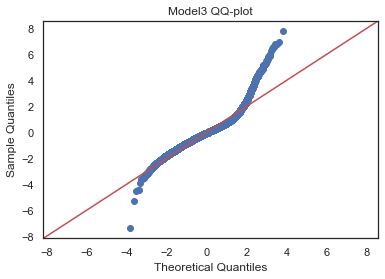

In [121]:
residuals3 = model3.resid
fig3 = sm.graphics.qqplot(residuals3, dist=stats.norm, line='45', fit=True)
plt.title('Model3 QQ-plot')
fig3.show();

> My revisions still show a similar skew to the first model I did. There is a potential to re-work the data to be more normal still.

# iNTERPRET

In [108]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     770.0
Date:                Mon, 09 Dec 2019   Prob (F-statistic):               0.00
Time:                        17:06:44   Log-Likelihood:            -1.8094e+05
No. Observations:               13947   AIC:                         3.620e+05
Df Residuals:                   13866   BIC:                         3.627e+05
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -2.722e+05   9466.914    -28.756      0.000   -2.91e+05   -2.54e+05
bedrooms               -1.102e+04   1392.416     -7.912      0.000   -1.37e+04   -8287.796
bathrooms               1.569e+04   2214.696      7.087      0.000    1.14e+04       2e+04
sqft_living             6.684e+05   1.13e+04     59.369      0.000    6.46e+05     6.9e+05
sqft_lot                1.183e+05   1.19e+04      9.965      0.000     9.5e+04    1.42e+05
waterfront              1.403e-09   3.45e-11     40.666      0.000    1.33e-09    1.47e-09
grade                   5.779e+04   1467.767     39.375      0.000    5.49e+04    6.07e+04
sqft_basement          -6.719e+04   5110.231    -13.149      0.000   -7.72e+04   -5.72e+04
flrs_(0.5, 1.0]        -1.213e+04   2609.426     -4.650      0.000   -1.72e+04   -7019.893
cond_(1, 2]            -1.007e+05   9100.880    -11.064      0.000   -1.19e+05   -8.29e+04
cond_(2, 3]            -8.369e+04   3581.974    -23.364      0.000   -9.07e+04   -7.67e+04
cond_(3, 4]            -6.338e+04   3578.620    -17.711      0.000   -7.04e+04   -5.64e+04
cond_(4, 5]            -2.447e+04   4202.311     -5.822      0.000   -3.27e+04   -1.62e+04
yr_built_(1975, 2016]  -3.683e+04   2799.248    -13.156      0.000   -4.23e+04   -3.13e+04
zipcode_(98001, 98002]  2.779e+04   1.14e+04      2.428      0.015    5352.776    5.02e+04
zipcode_(98002, 98003]   644.8292   1.02e+04      0.063      0.950   -1.94e+04    2.07e+04
zipcode_(98003, 98004]  6.015e+05    1.1e+04     54.641      0.000     5.8e+05    6.23e+05
zipcode_(98004, 98005]  3.128e+05   1.24e+04     25.316      0.000    2.89e+05    3.37e+05
zipcode_(98005, 98006]  2.803e+05   9206.965     30.446      0.000    2.62e+05    2.98e+05
zipcode_(98006, 98007]  2.506e+05   1.27e+04     19.732      0.000    2.26e+05    2.76e+05
zipcode_(98007, 98008]    2.5e+05   1.02e+04     24.399      0.000     2.3e+05     2.7e+05
zipcode_(98008, 98010]  8.185e+04   1.57e+04      5.198      0.000     5.1e+04    1.13e+05
zipcode_(98010, 98011]  1.454e+05   1.12e+04     12.959      0.000    1.23e+05    1.67e+05
zipcode_(98011, 98014]  9.482e+04   1.51e+04      6.263      0.000    6.51e+04    1.24e+05
zipcode_(98014, 98019]  1.023e+05   1.17e+04      8.736      0.000    7.93e+04    1.25e+05
zipcode_(98019, 98022]  1.341e+04   1.17e+04      1.145      0.252   -9549.282    3.64e+04
zipcode_(98022, 98023] -1.466e+04   8787.664     -1.669      0.095   -3.19e+04    2561.028
zipcode_(98023, 98024]  1.495e+05    1.9e+04      7.883      0.000    1.12e+05    1.87e+05
zipcode_(98024, 98027]  1.932e+05   9348.282     20.665      0.000    1.75e+05    2.12e+05
zipcode_(98027, 98028]  1.392e+05   1.04e+04     13.345      0.000    1.19e+05     1.6e+05
zipcode_(98028, 98029]  2.272e+05   9799.849     23.183      0.000    2.08e+05  

* ###### CONSTANT = -$270,000.00

* BEDROOMS = -$9,762.65

* BATHROOMS = $14,600.00

* SQFT_LIVING = $664,500.00

* SQFT_LOT = $121,300.00

* WATERFRONT = $0.0000000003174

* GRADE = $57,740.00

* SQFT_BASEMENT = -$67,720.00

* FLOOR DUMMY = -$9,794.43

* COND 2 = -$100,000.00

* COND 3 = -$83,380.00

* COND 4 = -$60,900.00

* COND 5 = -$25,760.00

* YR BUILT DUMMY = -$39,260.00

* ZIPCODE DUMMIES = A majority of them are positive. Only one will come into play when predicting any given home so I will not list them all out.

> Interestingly, the constant demonstrates a negative y-intercept for my model. In addition, a few of the features such as **bedrooms** and **floors dummy** actually _reduce_ the price of the home.

> The square footage features carry different influences on the price and seem to indicate living and lot square footage increases allowing space for the other features to subtract from. Additionally grade, although not much comparatively, contributes postiviely to price.

> Zipcodes can contribute as much as 841,200 or -27,500 to the home price depending on the zipcode it falls in

# Plots for presentation

In [186]:
x1 = x_train['sqft_living'].copy()
x3 = x_train['grade'].copy()
x4 = x_train['sqft_lot'].copy()
x5 = x_train['bathrooms'].copy() 
x6 = x_train['bedrooms'].copy()
x7 = x_train['waterfront'].copy()
x8 = x_train['flrs_(0.5, 1.0]'].copy()
y1 = y_train.copy()
x2 = [x8.min(),x8.max()]
y2 = pd.Series(data=[y_hat_train1.min(), y_hat_train1.max()])

In [149]:
y2

0       6953.5
1    1454560.0
dtype: float64

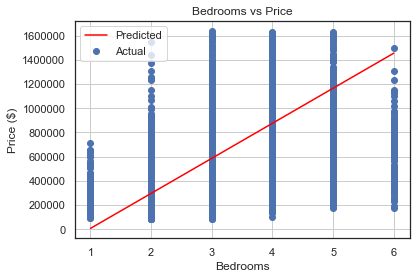

In [180]:
plt.scatter(x6, y1, label='Actual')
plt.plot(x2, y2, c='red', label='Predicted')
plt.xlabel('Bedrooms')
plt.ylabel('Price ($)')
plt.title('Bedrooms vs Price')
plt.grid()
plt.legend();

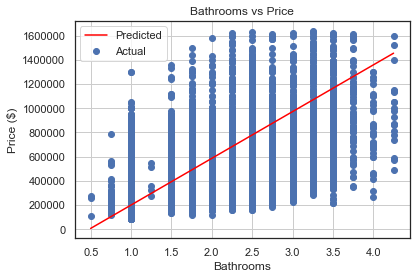

In [178]:
plt.scatter(x5, y1, label='Actual')
plt.plot(x2, y2, c='red', label='Predicted')
plt.xlabel('Bathrooms')
plt.ylabel('Price ($)')
plt.title('Bathrooms vs Price')
plt.grid()
plt.legend();

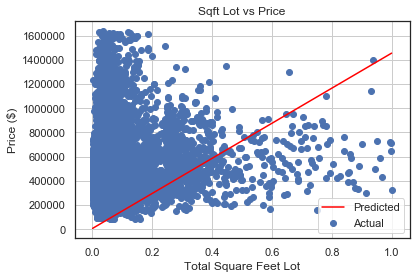

In [176]:
plt.scatter(x4, y1, label='Actual')
plt.plot(x2, y2, c='red', label='Predicted')
plt.xlabel('Total Square Feet Lot')
plt.ylabel('Price ($)')
plt.title('Sqft Lot vs Price')
plt.grid()
plt.legend();

> In this graph, 0 represents **~520 sqft** and 1 represents **~137,214 sqft**. 

> Each 0.2 tick represents **~876 sqft**.

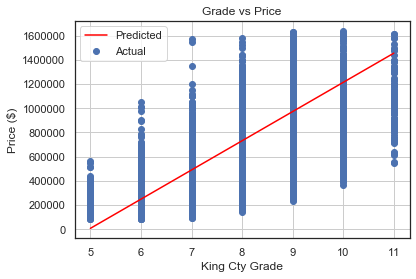

In [173]:
plt.scatter(x3, y1, label='Actual')
plt.plot(x2, y2, c='red', label='Predicted')
plt.xlabel('King Cty Grade')
plt.ylabel('Price ($)')
plt.title('Grade vs Price')
plt.grid()
plt.legend();

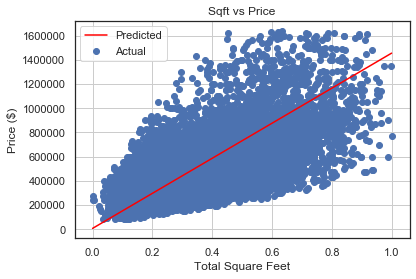

In [169]:
plt.scatter(x1, y1, label='Actual')
plt.plot(x2, y2, c='red', label='Predicted')
plt.xlabel('Total Square Feet')
plt.ylabel('Price ($)')
plt.title('Sqft vs Price')
plt.grid()
plt.legend();

> In this graph, 0 represents **~370 sqft** and 1 represents **~4750 sqft**. 

> Each 0.2 tick represents **~876 sqft**.

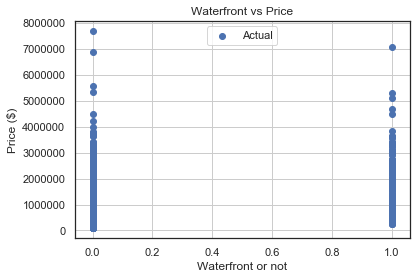

In [193]:
plt.scatter(kc_house_newidx2['waterfront'], kc_house_newidx2['price'], label='Actual')
plt.xlabel('Waterfront or not')
plt.ylabel('Price ($)')
plt.title('Waterfront vs Price')
plt.grid()
plt.legend(loc='upper center');

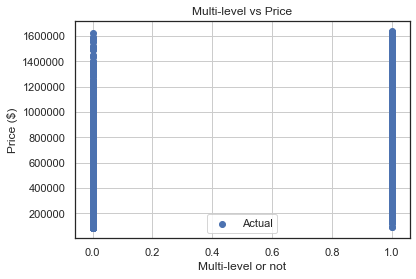

In [188]:
plt.scatter(x8, y1, label='Actual')
plt.xlabel('Multi-level or not')
plt.ylabel('Price ($)')
plt.title('Multi-level vs Price')
plt.grid()
plt.legend();

# CONCLUSIONS & RECOMMENDATIONS

> Summarize your conclusions and bullet-point your list of recommendations, which are based on your modeling results.

* To answer my questions, my model indicates that all else held equal:

> A home with a waterfront view does not have a real effect on the price of a home. Not even a single penny.

> A multi-leveled home is almost ten-thousand dollars cheaper than a single-level. This is suprising but really isn't much proportionally since the average home price for this data was 492,726. This works out to approximately 2% of the mean house price.

> The top three positive contributors are (most to least):
* Sqft_living
* Sqft_lot
* Grade

> The top three negative contributors are (most to least):
* Condition level two
* Condition level three
* Sqft_basement

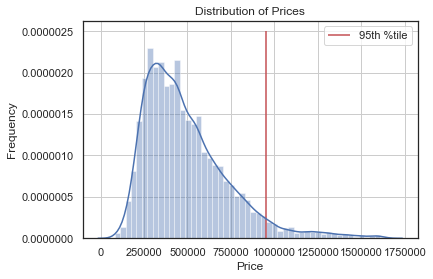

In [229]:
sns.distplot(price_series);
plt.vlines(950000, ymin=0, ymax=0.0000025, label='95th %tile', colors='r')
plt.xlabel('Price')
plt.ylabel('Frequency');
plt.title('Distribution of Prices');
plt.grid()
plt.legend();

In [226]:
price_series.quantile(q=.95)

950000.0

### My Recommendations

* For someone looking to sell their home, they **definitely** need to ensure that the condition of the home is not subpar and do whatever to ensure King County gives the home a grade as high as possible. Each grade of improvement will raise the price by 57k and for condition the reduction can go from -100k down to -25k.


* I would also recommend them to maximize the amount of square footage within the home by **any means**. Otherwise, a home with a large lot will help (but is harder to control).


* If they want to add any rooms to the home, I would recommend adding a bathroom over a bedroom, as my model suggests (although small) a decrease dor each bedroom added to a home. In contrast, the bathrooms give a small boost. 


* I would not recommend when expanding a home to add a floor or expand the basement level (if one applies). In both cases my model shows a decrease for the overall price of a home. The basement feature demonstrates -67k as a maximum loss to a home's value.